## COMPAS Analysis using Aequitas
<a id='top_cell'></a>
Recent work in the Machine Learning community has raised concerns about the risk of unintended bias in Algorithmic Decision-Making systems, affecting individuals unfairly. While many bias metrics and fairness definitions have been proposed in recent years, the community has not reached a consensus on which definitions and metrics should be used, and there has been very little empirical analyses of real-world problems using the proposed metrics. 

We present the Aequitas toolkit as an intuitive addition to the machine learning workflow, enabling users to to seamlessly test models for several bias and fairness metrics in relation to multiple population groups. We believe the tool will faciliate informed and equitable decision-making around developing and deploying predictive risk-assessment tools for both machine learnining practitioners and policymakers, allowing researchers and program managers to answer a host of questions related to machine learning models, including:

- [What biases exist in my model?](#existing_biases)
    - [What is the distribution of groups, predicted scores, and labels across my dataset?](#xtab)
    - [What are bias metrics across groups?](#xtab_metrics)
    - [How do I interpret biases in my model?](#interpret_bias)
    - [How do I visualize biases in my model?](#bias_viz)

- [What levels of disparity exist between population groups?](#disparities)
    - [How does the selected reference group affect disparity calculations?](#disparity_calc)
    - [How do I interpret calculated disparity ratios?](#interpret_disp)
    - [How do I visualize disparities in my model?](#disparity_viz) 

- [How do I assess model fairness??](#fairness)
    - [How do I interpret parities?](#interpret_fairness)
    - [How do I visualize bias metric parity?](#fairness_group_viz)
    - [How do I visualize parity between groups in my model?](#fairness_disp_viz) 


We apply the toolkit to the COMPAS dataset reported on by ProPublica below.

### Background

In 2016, ProPublica reported on racial inequality in automated criminal risk assessment algorithms. The [report](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing) is based on [this analysis](https://github.com/propublica/compas-analysis). Using a clean version of the COMPAS dataset from the ProPublica GitHub repo, we demostrate the use of the Aequitas bias reporting tool.

Northpointe's COMPAS (Correctional Offender Management Profiling for Alternative Sanctions) is one of the most widesly utilized risk assessment tools/ algorithms within the criminal justice system for guiding decisions such as how to set bail. The ProPublica dataset represents two years of COMPAS predicitons from Broward County, FL.

In [1]:
import pandas as pd
import seaborn as sns
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
from aequitas.plotting import Plot

# import warnings; warnings.simplefilter('ignore')

%matplotlib inline

In [2]:
df = pd.read_csv("../../../examples/data/compas_for_aequitas.csv")
df.head()

,entity_id,score,label_value,race,sex,age_cat
0,1,0.0,0,Other,Male,Greater than 45
1,3,0.0,1,African-American,Male,25 - 45
2,4,0.0,1,African-American,Male,Less than 25
3,5,1.0,0,African-American,Male,Less than 25
4,6,0.0,0,Other,Male,25 - 45


In [3]:
df.shape

(7214, 6)

## Pre-Aequitas: Exploring the COMPAS Dataset

__Risk assessment by race__

COMPAS produces a risk score that predicts a person's likelihood of commiting a crime in the next two years. The output is a score between 1 and 10 that maps to low, medium or high. For Aequitas, we collapse this to a binary prediction. A score of 0 indicates a prediction of "low" risk according to COMPAS, while a 1 indicates "high" or "medium" risk.

This categorization is based on ProPublica's interpretation of Northpointe's practioner guide:

    "According to Northpointe’s practitioners guide, COMPAS “scores in the medium and high range 
    garner more interest from supervision agencies than low scores, as a low score would suggest 
    there is little risk of general recidivism,” so we considered scores any higher than “low” to 
    indicate a risk of recidivism."

In the bar charts below, we see a large difference in how these scores are distributed by race, with a majority of white and Hispanic people predicted as low risk (score = 0) and a majority of black people predicted high and medium risk (score = 1). We also see that while the majority of people in age categories over 25 are predicted as low risk (score = 0), the majority of people below 25 are predicted as high and medium risk (score = 1).

In [4]:
aq_palette = sns.diverging_palette(225, 35, n=2)

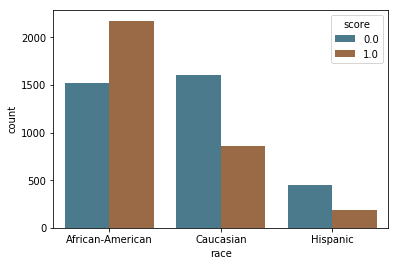

In [5]:
by_race = sns.countplot(x="race", hue="score", data=df[df.race.isin(['African-American', 'Caucasian', 'Hispanic'])], palette=aq_palette)

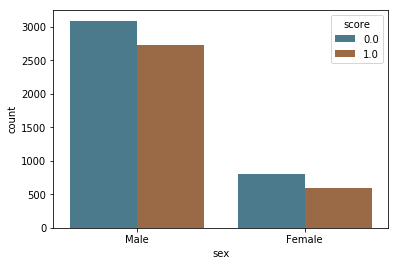

In [6]:
by_sex = sns.countplot(x="sex", hue="score", data=df, palette=aq_palette)

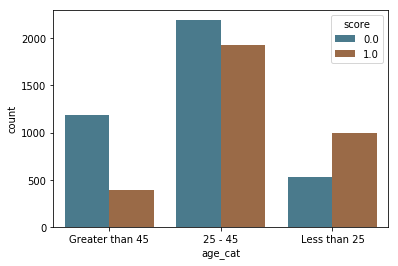

In [7]:
by_age = sns.countplot(x="age_cat", hue="score", data=df, palette=aq_palette)

__Levels of recidivism__

This dataset includes information about whether or not the subject recidivated, and so we can directly test the accuracy of the predictions. First, we visualize the recidivsm rates across race. 

Following ProPublica, we defined recidivism as a new arrest within two years. (If a person recidivates, `label_value` = 1). They "based this decision on Northpointe’s practitioners guide, which says that its recidivism score is meant to predict 'a new misdemeanor or felony offense within two years of the COMPAS administration date.'"




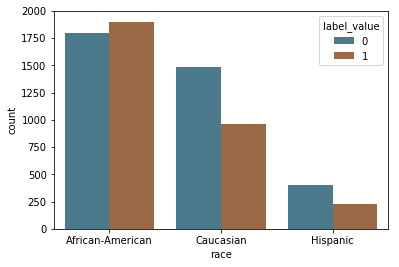

In [8]:
label_by_race = sns.countplot(x="race", hue="label_value", data=df[df.race.isin(['African-American', 'Caucasian', 'Hispanic'])], palette=aq_palette)

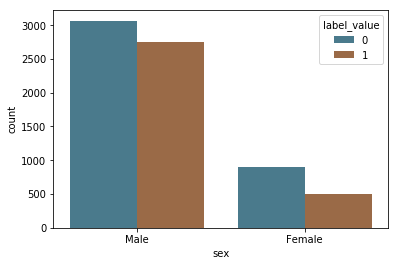

In [9]:
label_by_age = sns.countplot(x="sex", hue="label_value", data=df, palette=aq_palette)

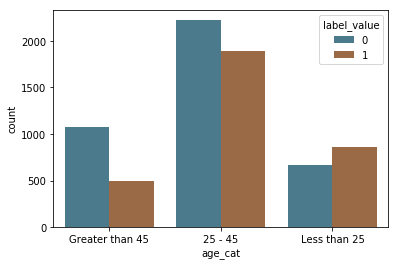

In [10]:
label_by_sex = sns.countplot(x="age_cat", hue="label_value", data=df, palette=aq_palette)

## Putting Aequitas to the task

The graphs above show the base rates for recidivism are higher for black defendants compared to white defendants (.51 vs .39), though the predictions do not match the base rates. 

Practitioners face the challenge of determining whether or not such patterns reflect bias or not. The fact that there are multiple ways to measure bias adds complexity to the decision-making process. With Aequitas, we provide a tool that automates the reporting of various fairness metrics to aid in this process.

Applying Aequitas progammatically is a three step process represented by three python classes: 

`Group()`: Define groups 

`Bias()`: Calculate disparities

`Fairness()`: Assert fairness

Each class builds on the previous one expanding the output DataFrame.


### Data Formatting

Data for this example was preprocessed for compatibility with Aequitas. **The Aequitas tool always requires a `score` column and requires a binary `label_value` column for supervised metrics**, (i.e., False Discovery Rate, False Positive Rate, False Omission Rate, and False Negative Rate).

Preprocessing includes but is not limited to checking for mandatory `score` and `label_value` columns as well as at least one column representing attributes specific to the data set. See [documentation](../input_data.html) for more information about input data.

Note that while `entity_id` is not necessary for this example, Aequitas recognizes `entity_id` as a reserve column name and will not recognize it as an attribute column.

[Back to Top](#top_cell)
<a id='existing_biases'></a>

## What biases exist in my model?

### _Aequitas Group() Class_

<a id='xtab'></a>

### What is the distribution of groups, predicted scores, and labels across my dataset?

Aequitas's `Group()` class enables researchers to evaluate biases across all subgroups in their dataset by assembling a confusion matrix of each subgroup, calculating commonly used metrics such as false positive rate and false omission rate, as well as counts by group and group prevelance among the sample population. 

<a id='counts_description'></a>
The **`get_crosstabs()`** method tabulates a confusion matrix for each subgroup and calculates commonly used metrics such as false positive rate and false omission rate. It also provides counts by group and group prevelances.

#### Group Counts Calculated:

| Count Type | Column Name |
| --- | --- |
| False Positive Count | 'fp' |
| False Negative Count | 'fn' |
| True Negative Count | 'tn' |
| True Positive Count | 'tp' |
| Predicted Positive Count | 'pp' |
| Predicted Negative Count | 'pn' |
| Count of Negative Labels in Group | 'group_label_neg' |
| Count of Positive Labels in Group | 'group_label_pos' | 
| Group Size | 'group_size'|
| Total Entities | 'total_entities' |

#### Absolute Metrics Calculated:

| Metric | Column Name |
| --- | --- |
| True Positive Rate | 'tpr' |
| True Negative Rate | 'tnr' |
| False Omission Rate | 'for' |
| False Discovery Rate | 'fdr' |
| False Positive Rate | 'fpr' |
| False Negative Rate | 'fnr' |
| Negative Predictive Value | 'npv' |
| Precision | 'precision' |
| Predicted Positive Ratio$_k$ | 'ppr' |
| Predicted Positive Ratio$_g$ | 'pprev' |
| Group Prevalence | 'prev' |


**Note**: The **`get_crosstabs()`** method expects a dataframe with predefined columns `score`, and `label_value` and treats other columns (with a few exceptions) as attributes against which to test for disparities. In this case, we include `race`, `sex` and `age_cat`. 

In [11]:
g = Group()
xtab, _ = g.get_crosstabs(df)

model_id, score_thresholds 0 {'rank_abs': [3317]}


[Back to Top](#top_cell)
<a id='xtab_metrics'></a>

### What are bias metrics across groups?

Once you have run the `Group()` class **`get_crosstabs()`** method, you'll have a dataframe of the [group counts](#counts_description) and [group value bias metrics](#counts_description).

The `Group()` class has a **`list_absolute_metrics()`** method, which you can use for faster slicing to view just  counts or bias metrics.

In [12]:
absolute_metrics = g.list_absolute_metrics(xtab)

#### View calculated counts across sample population groups

In [13]:
xtab[[col for col in xtab.columns if col not in absolute_metrics]]

,model_id,score_threshold,k,attribute_name,attribute_value,pp,pn,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities
0,0,binary 0/1,3317,race,African-American,2174,1522,805,532,990,1369,1901,1795,3696,7214
1,0,binary 0/1,3317,race,Asian,8,24,2,3,21,6,9,23,32,7214
2,0,binary 0/1,3317,race,Caucasian,854,1600,349,461,1139,505,966,1488,2454,7214
3,0,binary 0/1,3317,race,Hispanic,190,447,87,129,318,103,232,405,637,7214
4,0,binary 0/1,3317,race,Native American,12,6,3,1,5,9,10,8,18,7214
5,0,binary 0/1,3317,race,Other,79,298,36,90,208,43,133,244,377,7214
6,0,binary 0/1,3317,sex,Female,591,804,288,195,609,303,498,897,1395,7214
7,0,binary 0/1,3317,sex,Male,2726,3093,994,1021,2072,1732,2753,3066,5819,7214
8,0,binary 0/1,3317,age_cat,25 - 45,1924,2185,741,706,1479,1183,1889,2220,4109,7214
9,0,binary 0/1,3317,age_cat,Greater than 45,394,1182,181,285,897,213,498,1078,1576,7214


#### View calculated absolute metrics for each sample population group

In [14]:
xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,race,African-American,0.72,0.55,0.35,0.37,0.45,0.28,0.65,0.63,0.66,0.59,0.51
1,race,Asian,0.67,0.91,0.12,0.25,0.09,0.33,0.88,0.75,0.00,0.25,0.28
2,race,Caucasian,0.52,0.77,0.29,0.41,0.23,0.48,0.71,0.59,0.26,0.35,0.39
3,race,Hispanic,0.44,0.79,0.29,0.46,0.21,0.56,0.71,0.54,0.06,0.30,0.36
4,race,Native American,0.90,0.62,0.17,0.25,0.38,0.10,0.83,0.75,0.00,0.67,0.56
5,race,Other,0.32,0.85,0.30,0.46,0.15,0.68,0.70,0.54,0.02,0.21,0.35
6,sex,Female,0.61,0.68,0.24,0.49,0.32,0.39,0.76,0.51,0.18,0.42,0.36
7,sex,Male,0.63,0.68,0.33,0.36,0.32,0.37,0.67,0.64,0.82,0.47,0.47
8,age_cat,25 - 45,0.63,0.67,0.32,0.39,0.33,0.37,0.68,0.61,0.58,0.47,0.46
9,age_cat,Greater than 45,0.43,0.83,0.24,0.46,0.17,0.57,0.76,0.54,0.12,0.25,0.32


[Back to Top](#top_cell)
<a id='interpret_bias'></a>

### How do I interpret biases in my model? 
In the slice of the crosstab dataframe created by the `Group()` class **`get_crosstabs()`** method directly above, we see that African-Americans have a false positive rate (`fpr`) of 45%, while Caucasians have a false positive rate of only 23%. This means that African-American people are far more likely to be falsely labeled as high-risk than white people. On the other hand, false ommision rates (`for`) and false discovery rates (`fdr`) are much closer for those two groups.

[Back to Top](#top_cell)
<a id='bias_viz'></a>

## How do I visualize bias in my model?

Absolute group bias metrics metrics from the crosstab dataframe created by the `Group()` class **`get_crosstabs()`** can be visualized with two methods in the Aequitas `Plot()` class. 

One metric can be specified with **`plot_group_metric()`**, or a list of particular metrics of interest (or `'all'` metrics) can be plotted with **`plot_group_metric_all()`**.

In [15]:
aqp = Plot()

### Visualizing a single absolute group metric across all population groups
The chart below displays group metric False Negative Rate (fnr) calculated across each attribute, colored based on number of samples in the attribute group. 

We can see from the longer bars that across 'age_cat', 'sex', and 'race' attributes, the groups COMPAS incorrectly predicts as 'low' or 'medium' risk most often are 25-45, Male, and African American. From the darker coloring, we can also tell that these are the three largest populations in the data set.

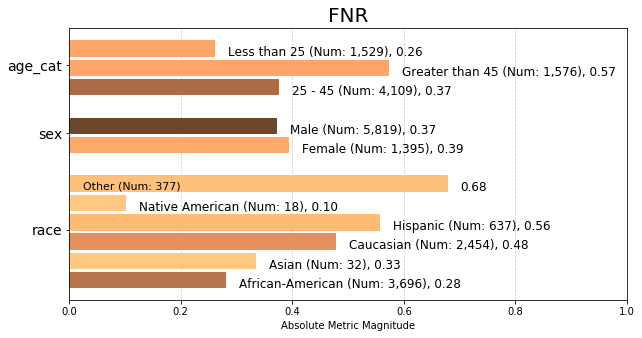

In [16]:
fnr = aqp.plot_group_metric(xtab, 'fnr')

### View group metrics for only groups over a certain size threshold
Extremely small group sizes increase standard error of estimates, and could be factors in prediction error such as false negatives. Use the `min_group` parameter to vizualize only those sample population groups above a user-specified percentage of the total sample size. When we remove groups below 5% of the sample size, we are left with only two of the six 'race' groups, as there are much smaller groups in that attribute category than in 'sex' or 'age_cat' (age cateogry). 

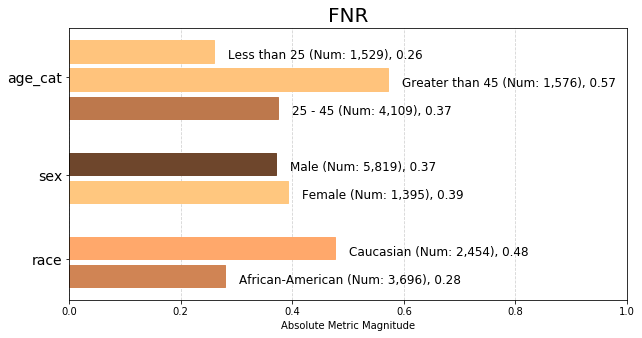

In [17]:
fnr = aqp.plot_group_metric(xtab, 'fnr', min_group_size=0.05)

### Visualizing multiple user-specified absolute group metrics across all population groups

The charts below display the all calculated group metrics across each attribute, colored based on absolute metric magnitude. The group size is included in parentheses for context.

We can see that the largest 'race' group, African Americans, are predicted positive more often than any other race group (predicted positive rate `PPR` of 0.66), and are more likely to be incorrectly classified as 'high' risk (false positive rate `FPR` of 0.45) than incorrectly classified as 'low' or 'medium' risk (false negative rate `FNR` of 0.28). Note that Native Americans are predicted positive at a higher _prevalence_ `PPREV`in relation to their group size than all other 'race groups' (predicted prevalence of 0.67). 

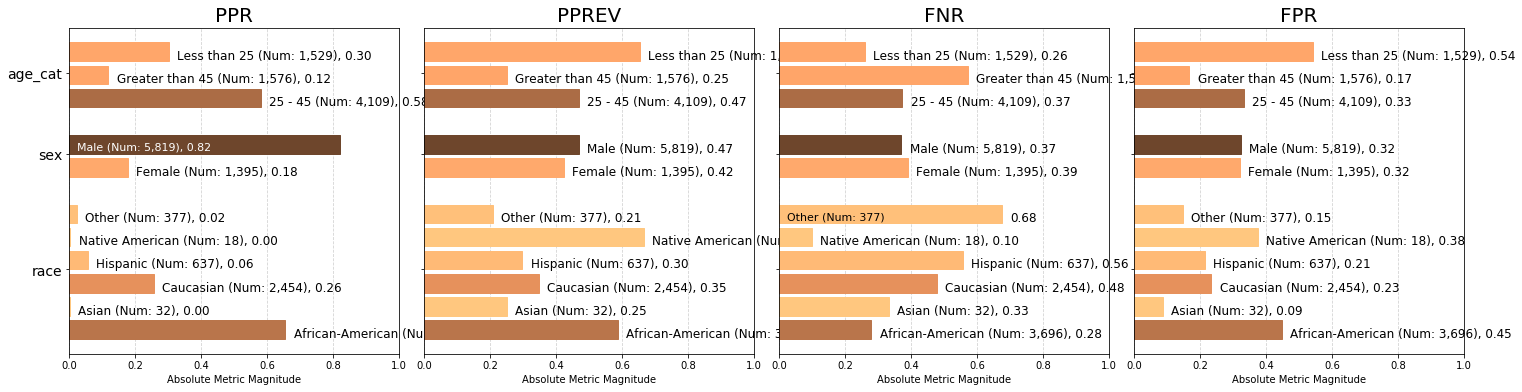

<Figure size 432x288 with 0 Axes>

In [18]:
p = aqp.plot_group_metric_all(xtab, metrics=['ppr','pprev','fnr','fpr'], ncols=4)

### Visualizing default absolute group metrics across all population groups
#### Default absolute group metrics
When visualizing more than one absolute group metric, you can specify a list of metrics, specify `'all'` metrics, or use the Aequitas default metrics by not supplying an argument:
- Predicted Positive Group Rate Disparity (pprev), 
- Predicted Positive Rate Disparity (ppr),  
- False Discovery Rate (fdr), 
- False Omission Rate (for)
- False Positive Rate (fpr)
- False Negative Rate (fnr)

The charts below display the default group metrics calculated across each attribute, colored based on number of samples in the attribute group. 

Note that the 45+ age category is almost twice as likely to be incorrectly included in an intervention group (false discovery rate `FDR` of 0.46) than incorrectly excluded from intervention (false omission rate `FOR` 0.24). We can also see that the model is equally likely to predict a woman as 'high' risk as it is for a man (false positive rate `FPR` of 0.32 for both Male and Female).

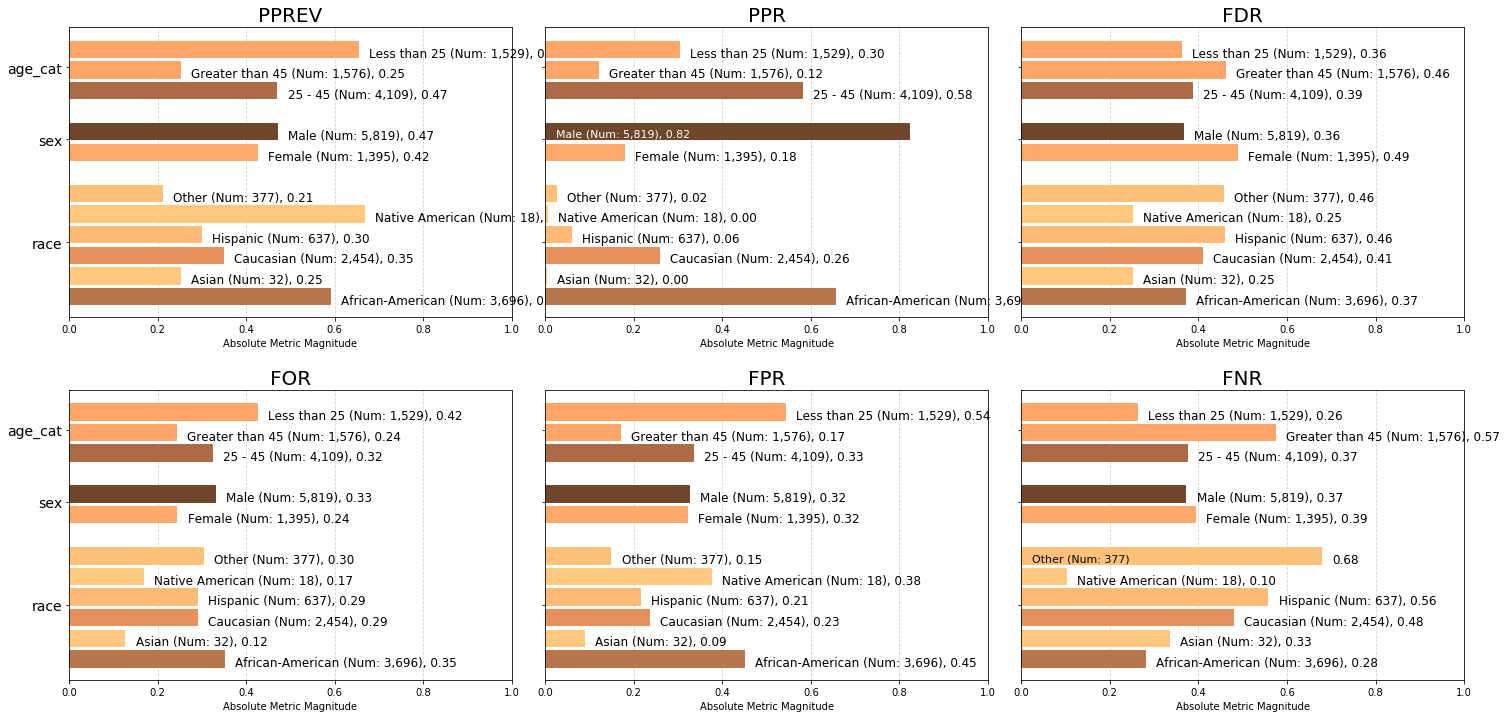

<Figure size 432x288 with 0 Axes>

In [19]:
a = aqp.plot_group_metric_all(xtab, ncols=3)

[Back to Top](#top_cell)
<a id='disparities'></a>

## What levels of disparity exist between population groups?

### _Aequitas Bias() Class_
We use the Aequitas `Bias()` class to calculate disparities between groups based on the crosstab returned by the `Group()` class **`get_crosstabs()`** method described above. Disparities are calculated as a ratio of a metric for a group of interest compared to a base group. For example, the False Negative Rate Disparity for black defendants vis-a-vis whites is:
$$Disparity_{FNR} =  \frac{FNR_{black}}{FNR_{white}}$$ 

Below, we use **`get_disparity_predefined_groups()`** which allows us to choose reference groups that clarify the output for the practitioner. 

The Aequitas `Bias()` class includes two additional get disparity functions: **`get_disparity_major_group()`** and **`get_disparity_min_metric()`**, which automate base group selection based on sample majority (across each attribute) and minimum value for each calculated bias metric, respectively.  

The **`get_disparity_predefined_groups()`** allows user to define a base group for each attribute, as illustrated below. 

#### Disparities Calculated Calcuated:

| Metric | Column Name |
| --- | --- |
| True Positive Rate Disparity | 'tpr_disprity' |
| True Negative Rate | 'tnr_disparity' |
| False Omission Rate | 'for_disparity' |
| False Discovery Rate | 'fdr_disparity' |
| False Positive Rate | 'fpr_disparity' |
| False NegativeRate | 'fnr_disparity' |
| Negative Predictive Value | 'npv_disparity' |
| Precision Disparity | 'precision_disparity' |
| Predicted Positive Ratio$_k$ Disparity | 'ppr_disparity' |
| Predicted Positive Ratio$_g$ Disparity | 'pprev_disparity' |


Columns for each disparity are appended to the crosstab dataframe, along with a column indicating the reference group for each calculated metric (denoted by `[METRIC NAME]_ref_group_value`). We see a slice of the dataframe with calculated metrics in the next section.

In [20]:
b = Bias()

#### Disparities calculated in relation to a user-specified group for each attribute

In [33]:
bdf = b.get_disparity_predefined_groups(xtab, original_df=df, 
                                        ref_groups_dict={'race':'Caucasian', 'sex':'Male', 'age_cat':'25 - 45'}, 
                                        alpha=0.05, check_significance=True, 
                                        mask_significance=True)
bdf.style

get_disparity_predefined_group()


,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev,label_value_significance,score_significance,fdr_disparity,fdr_ref_group_value,fdr_significance,fnr_disparity,fnr_ref_group_value,fnr_significance,for_disparity,for_ref_group_value,for_significance,fpr_disparity,fpr_ref_group_value,fpr_significance,npv_disparity,npv_ref_group_value,npv_significance,ppr_disparity,ppr_ref_group_value,ppr_significance,pprev_disparity,pprev_ref_group_value,pprev_significance,precision_disparity,precision_ref_group_value,precision_significance,tnr_disparity,tnr_ref_group_value,tnr_significance,tpr_disparity,tpr_ref_group_value,tpr_significance
0,0,binary 0/1,3317,race,African-American,0.720147,0.551532,0.34954,0.370285,0.448468,0.279853,0.65046,0.629715,2174,1522,0.655412,0.588203,805,532,990,1369,1901,1795,3696,7214,0.51434,True,True,0.906085,Caucasian,False,0.586416,Caucasian,True,1.21315,Caucasian,True,1.91209,Caucasian,False,0.913728,Caucasian,True,2.54567,Caucasian,True,1.69022,Caucasian,True,1.0649,Caucasian,False,0.720526,Caucasian,False,1.37755,Caucasian,True
1,0,binary 0/1,3317,race,Asian,0.666667,0.913043,0.125,0.25,0.0869565,0.333333,0.875,0.75,8,24,0.00241182,0.25,2,3,21,6,9,23,32,7214,0.28125,False,False,0.611748,Caucasian,False,0.698482,Caucasian,False,0.433839,Caucasian,False,0.370749,Caucasian,False,1.22915,Caucasian,False,0.00936768,Caucasian,False,0.718384,Caucasian,False,1.26832,Caucasian,False,1.19281,Caucasian,False,1.27525,Caucasian,False
2,0,binary 0/1,3317,race,Caucasian,0.522774,0.765457,0.288125,0.408665,0.234543,0.477226,0.711875,0.591335,854,1600,0.257462,0.348003,349,461,1139,505,966,1488,2454,7214,0.393643,False,False,1,Caucasian,False,1,Caucasian,False,1,Caucasian,False,1,Caucasian,False,1,Caucasian,False,1,Caucasian,False,1,Caucasian,False,1,Caucasian,False,1,Caucasian,False,1,Caucasian,False
3,0,binary 0/1,3317,race,Hispanic,0.443966,0.785185,0.288591,0.457895,0.214815,0.556034,0.711409,0.542105,190,447,0.0572807,0.298273,87,129,318,103,232,405,637,7214,0.364207,False,True,1.12046,Caucasian,False,1.16514,Caucasian,False,1.00162,Caucasian,False,0.915887,Caucasian,False,0.999346,Caucasian,False,0.222482,Caucasian,True,0.857099,Caucasian,True,0.916748,Caucasian,False,1.02577,Caucasian,False,0.849249,Caucasian,False
4,0,binary 0/1,3317,race,Native American,0.9,0.625,0.166667,0.25,0.375,0.1,0.833333,0.75,12,6,0.00361773,0.666667,3,1,5,9,10,8,18,7214,0.555556,False,True,0.611748,Caucasian,False,0.209544,Caucasian,False,0.578453,Caucasian,False,1.59885,Caucasian,False,1.17062,Caucasian,False,0.0140515,Caucasian,True,1.91569,Caucasian,True,1.26832,Caucasian,False,0.816506,Caucasian,False,1.72158,Caucasian,False
5,0,binary 0/1,3317,race,Other,0.323308,0.852459,0.302013,0.455696,0.147541,0.676692,0.697987,0.544304,79,298,0.0238167,0.209549,36,90,208,43,133,244,377,7214,0.352785,False,True,1.11508,Caucasian,False,1.41797,Caucasian,False,1.0482,Caucasian,False,0.629057,Caucasian,False,0.98049,Caucasian,False,0.0925059,Caucasian,True,0.602147,Caucasian,True,0.920466,Caucasian,False,1.11366,Caucasian,False,0.618447,Caucasian,False
6,0,binary 0/1,3317,sex,Female,0.608434,0.67893,0.242537,0.48731,0.32107,0.391566,0.757463,0.51269,591,804,0.178173,0.423656,288,195,609,303,498,897,1395,7214,0.356989,True,True,1.33642,Male,True,1.05581,Male,True,0.734738,Male,True,0.990343,Male,True,1.13071,Male,True,0.216801,Male,True,0.904348,Male,True,0.806925,Male,True,1.00463,Male,True,0.967101,Male,True
7,0,binary 0/1,3317,sex,Male,0.629132,0.675799,0.3301,0.364637,0.324201,0.370868,0.6699,0.635363,2726,3093,0.821827,0.468465,994,1021,2072,1732,2753,3066,5819,7214,0.473105,False,False,1,Male,False,1,Male,False,1,Male,False,1,Male,False,1,Male,False,1,Male,False,1,Male,False,1,Male,False,1,Male,False,1,Male,False
8,0,binary 0/1,3317,age_cat,25 - 45,0.626257,0.666216,0.323112,0.385135,0.333784,0.373743,0.676888,0.

The `Bias()` class includes a method to quickly return a list of calculated disparities from the dataframe returned by the **`get_disparity_`** methods.

In [67]:
# View disparity metrics added to dataframe
bdf[['attribute_name', 'attribute_value'] +
     b.list_disparities(bdf) + b.list_significance(bdf)].style

,attribute_name,attribute_value,fdr_disparity,fnr_disparity,for_disparity,fpr_disparity,npv_disparity,ppr_disparity,pprev_disparity,precision_disparity,tnr_disparity,tpr_disparity,label_value_significance,score_significance,fdr_significance,fnr_significance,for_significance,fpr_significance,npv_significance,ppr_significance,pprev_significance,precision_significance,tnr_significance,tpr_significance
0,race,African-American,0.906085,0.586416,1.21315,1.91209,0.913728,2.54567,1.69022,1.0649,0.720526,1.37755,True,True,False,True,True,False,True,True,True,False,False,True
1,race,Asian,0.611748,0.698482,0.433839,0.370749,1.22915,0.00936768,0.718384,1.26832,1.19281,1.27525,False,False,False,False,False,False,False,False,False,False,False,False
2,race,Caucasian,1,1,1,1,1,1,1,1,1,1,False,False,False,False,False,False,False,False,False,False,False,False
3,race,Hispanic,1.12046,1.16514,1.00162,0.915887,0.999346,0.222482,0.857099,0.916748,1.02577,0.849249,False,True,False,False,False,False,False,True,True,False,False,False
4,race,Native American,0.611748,0.209544,0.578453,1.59885,1.17062,0.0140515,1.91569,1.26832,0.816506,1.72158,False,True,False,False,False,False,False,True,True,False,False,False
5,race,Other,1.11508,1.41797,1.0482,0.629057,0.98049,0.0925059,0.602147,0.920466,1.11366,0.618447,False,True,False,False,False,False,False,True,True,False,False,False
6,sex,Female,1.33642,1.05581,0.734738,0.990343,1.13071,0.216801,0.904348,0.806925,1.00463,0.967101,True,True,True,True,True,True,True,True,True,True,True,True
7,sex,Male,1,1,1,1,1,1,1,1,1,1,False,False,False,False,False,False,False,False,False,False,False,False
8,age_cat,25 - 45,1,1,1,1,1,1,1,1,1,1,False,False,False,False,False,False,False,False,False,False,False,False
9,age_cat,Greater than 45,1.1928,1.53124,0.746232,0.503031,1.12114,0.204782,0.533914,0.879232,1.24899,0.682963,True,True,True,True,True,True,True,True,True,True,True,True


[Back to Top](#top_cell)
<a id='interpret_disp'></a>

### How do I interpret calculated disparity ratios?
The calculated disparities from the dataframe returned by the `Bias()` class **`get_disparity_`** methods are in relation to a reference group, which will always have a disparity of 1.0.

The differences in False Positive Rates, noted in the discussion of the `Group()` class above, are clarified using the disparity ratio (`fpr_disparity`). Black people are falsely identified as being high or medium risks 1.9 times the rate for white people. 

As seen above, False Discovery Rates have much less disparity (`fdr_disparity`), or fraction of false postives over predicted positive in a group. As reference groups have disparity = 1 by design in Aequitas, the lower disparity is highlighted by the `fdr_disparity` value close to 1.0 (0.906) for the race attribute group 'African-American' when disparities are calculated using predefined base group 'Caucasian'. Note that COMPAS is calibrated to  balance False Positive Rate and False Discovery Rates across groups.

[Back to Top](#top_cell)
<a id='disparity_calc'></a>

### How does the selected reference group affect disparity calculations?

Disparities calculated in the the Aequitas `Bias()` class based on the crosstab returned by the `Group()` class **`get_crosstabs()`** method can be derived using several different base gorups. In addition to using user-specified groups illustrated above, Aequitas can automate base group selection based on dataset characterisitcs:

#### Evaluating disparities calculated in relation to a different 'race' reference group
Changing even one attribute in the predefined groups will alter calculated disparities. When a differnet pre-defined group 'Hispanic' is used, we can see that Black people are 2.1 times more likely to be falsely identified as being high or medium risks as Hispanic people are (compared to 1.9 times more likely than white people), and even less likely to be falsely identified as low risk when compared to Hispanic people rather than white people.

In [37]:
hbdf = b.get_disparity_predefined_groups(xtab, original_df=df, 
                                         ref_groups_dict={'race':'Hispanic', 'sex':'Male', 'age_cat':'25 - 45'},
                                         alpha=0.05,
                                         check_significance=True,
                                         mask_significance=False, 
                                         selected_significance=['fpr', 'for', 'fdr'])


get_disparity_predefined_group()


In [69]:
# View disparity metrics added to dataframe
hbdf[['attribute_name', 'attribute_value'] +  
     b.list_disparities(hbdf) + b.list_significance(hbdf)]

,attribute_name,attribute_value,fdr_disparity,fnr_disparity,for_disparity,fpr_disparity,npv_disparity,ppr_disparity,pprev_disparity,precision_disparity,tnr_disparity,tpr_disparity,label_value_significance,score_significance,fdr_significance,for_significance,fpr_significance
0,race,African-American,0.808669,0.503301,1.211197,2.087696,0.914326,11.442105,1.972030,1.161610,0.702423,1.622079,1.071670e-12,1.698640e-43,2.101379e-02,1.380038e-02,2.101379e-02
1,race,Asian,0.545977,0.599483,0.433140,0.404798,1.229953,0.042105,0.838158,1.383495,1.162838,1.501618,3.408975e-01,5.600792e-01,2.490853e-01,8.246864e-02,2.490853e-01
2,race,Caucasian,0.892487,0.858266,0.998387,1.091838,1.000654,4.494737,1.166727,1.090812,0.974874,1.177511,1.743464e-01,1.560902e-02,2.137023e-01,9.846792e-01,2.137023e-01
3,race,Hispanic,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
4,race,Native American,0.545977,0.179845,0.577519,1.745690,1.171384,0.063158,2.235088,1.383495,0.795991,2.027184,9.746342e-02,8.217490e-04,1.615220e-01,5.129970e-01,1.615220e-01
5,race,Other,0.995199,1.216996,1.046512,0.686829,0.981132,0.415789,0.702541,1.004056,1.085679,0.728228,7.145330e-01,1.433433e-03,9.738238e-01,6.940727e-01,9.738238e-01
6,sex,Female,1.336425,1.055810,0.734738,0.990343,1.130710,0.216801,0.904348,0.806925,1.004633,0.967101,1.238621e-15,2.433115e-03,6.977574e-08,4.948025e-07,6.977574e-08
7,sex,Male,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
8,age_cat,25 - 45,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
9,age_cat,Greater than 45,1.192804,1.531238,0.746232,0.503031,1.121136,0.204782,0.533914,0.879232,1.248989,0.682963,3.843129e-24,2.277827e-57,7.096257e-03,3.045872e-07,7.096257e-03


#### Disparities calculated in relation to sample population majority group (in terms of group prevalence) for each attribute
The majority population groups for each attribute ('race', 'sex', 'age_cat') in the COMPAS dataset are 'African American', 'Male', and '25 - 45'. Using the **`get_disparity_major_group()`** method of calculation allows researchers to quickly evaluate how much more (or less often) other groups are falsely or correctly identified as high- or medium-risk in relation to the group they have the most data on.

In [40]:
majority_bdf = b.get_disparity_major_group(xtab, original_df=df)

get_disparity_major_group()


In [41]:
majority_bdf[['attribute_name', 'attribute_value'] +  calculated_disparities]

,attribute_name,attribute_value,fdr_disparity,fnr_disparity,for_disparity,fpr_disparity,npv_disparity,ppr_disparity,pprev_disparity,precision_disparity,tnr_disparity,tpr_disparity
0,race,African-American,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,race,Asian,0.675155,1.191103,0.357613,0.193897,1.345202,0.003680,0.425023,1.191015,1.655468,0.925737
2,race,Caucasian,1.103650,1.705274,0.824297,0.522987,1.094418,0.392824,0.591638,0.939052,1.387874,0.725927
3,race,Hispanic,1.236600,1.986883,0.825630,0.478997,1.093702,0.087397,0.507092,0.860874,1.423644,0.616493
4,race,Native American,0.675155,0.357331,0.476817,0.836180,1.281145,0.005520,1.133395,1.191015,1.133207,1.249744
5,race,Other,1.230663,2.418028,0.864031,0.328989,1.073066,0.036339,0.356253,0.864366,1.545620,0.448947
6,sex,Female,1.336425,1.055810,0.734738,0.990343,1.130710,0.216801,0.904348,0.806925,1.004633,0.967101
7,sex,Male,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
8,age_cat,25 - 45,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
9,age_cat,Greater than 45,1.192804,1.531238,0.746232,0.503031,1.121136,0.204782,0.533914,0.879232,1.248989,0.682963


#### Disparities calculated in relation to the minimum value for each metric

When you do not have a pre-existing don’t frame of reference or policy context for the dataset (ex: Caucasians or males historically favored), you may choose to view disparities in relation to the group with the lowest value for every disparity metric, as then every group's value will be at least 1.0, and relationships can be evaluated more linearly.


Note that disparities are much more varied, and may have larger magnitude, when the minimum value per metric is used as a reference group versus one of the other two methods.

In [70]:
min_metric_bdf = b.get_disparity_min_metric(df=xtab, original_df=df,
                                            check_significance=True)
min_metric_bdf.style

get_disparity_min_metric()


,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev,label_value_significance,score_significance,fdr_disparity,fdr_ref_group_value,fdr_significance,fnr_disparity,fnr_ref_group_value,fnr_significance,for_disparity,for_ref_group_value,for_significance,fpr_disparity,fpr_ref_group_value,fpr_significance,npv_disparity,npv_ref_group_value,npv_significance,ppr_disparity,ppr_ref_group_value,ppr_significance,pprev_disparity,pprev_ref_group_value,pprev_significance,precision_disparity,precision_ref_group_value,precision_significance,tnr_disparity,tnr_ref_group_value,tnr_significance,tpr_disparity,tpr_ref_group_value,tpr_significance
0,0,binary 0/1,3317,race,African-American,0.720147,0.551532,0.34954,0.370285,0.448468,0.279853,0.65046,0.629715,2174,1522,0.655412,0.588203,805,532,990,1369,1901,1795,3696,7214,0.51434,True,True,1.48114,Asian,False,2.79853,Native American,False,2.79632,Asian,True,5.15738,Asian,False,1,African-American,False,271.75,Asian,True,2.807,Other,True,1.16161,Hispanic,True,1,African-American,False,2.22743,Other,False
1,0,binary 0/1,3317,race,Asian,0.666667,0.913043,0.125,0.25,0.0869565,0.333333,0.875,0.75,8,24,0.00241182,0.25,2,3,21,6,9,23,32,7214,0.28125,False,False,1,Asian,False,3.33333,Native American,False,1,Asian,False,1,Asian,False,1.3452,African-American,True,1,Asian,False,1.19304,Other,False,1.3835,Hispanic,False,1.65547,African-American,False,2.06202,Other,False
2,0,binary 0/1,3317,race,Caucasian,0.522774,0.765457,0.288125,0.408665,0.234543,0.477226,0.711875,0.591335,854,1600,0.257462,0.348003,349,461,1139,505,966,1488,2454,7214,0.393643,False,False,1.63466,Asian,False,4.77226,Native American,False,2.305,Asian,False,2.69724,Asian,False,1.09442,African-American,True,106.75,Asian,False,1.66072,Other,True,1.09081,Hispanic,False,1.38787,African-American,False,1.61695,Other,False
3,0,binary 0/1,3317,race,Hispanic,0.443966,0.785185,0.288591,0.457895,0.214815,0.556034,0.711409,0.542105,190,447,0.0572807,0.298273,87,129,318,103,232,405,637,7214,0.364207,False,False,1.83158,Asian,False,5.56034,Native American,False,2.30872,Asian,False,2.47037,Asian,False,1.0937,African-American,True,23.75,Asian,False,1.4234,Other,True,1,Hispanic,False,1.42364,African-American,True,1.3732,Other,False
4,0,binary 0/1,3317,race,Native American,0.9,0.625,0.166667,0.25,0.375,0.1,0.833333,0.75,12,6,0.00361773,0.666667,3,1,5,9,10,8,18,7214,0.555556,False,True,1,Asian,False,1,Native American,False,1.33333,Asian,False,4.3125,Asian,False,1.28114,African-American,False,1.5,Asian,True,3.18143,Other,True,1.3835,Hispanic,False,1.13321,African-American,False,2.78372,Other,False
5,0,binary 0/1,3317,race,Other,0.323308,0.852459,0.302013,0.455696,0.147541,0.676692,0.697987,0.544304,79,298,0.0238167,0.209549,36,90,208,43,133,244,377,7214,0.352785,False,False,1.82278,Asian,False,6.76692,Native American,False,2.41611,Asian,False,1.69672,Asian,False,1.07307,African-American,False,9.875,Asian,False,1,Other,False,1.00406,Hispanic,False,1.54562,African-American,False,1,Other,False
6,0,binary 0/1,3317,sex,Female,0.608434,0.67893,0.242537,0.48731,0.32107,0.391566,0.757463,0.51269,591,804,0.178173,0.423656,288,195,609,303,498,897,1395,7214,0.356989,False,False,1.33642,Male,True,1.05581,Male,True,1,Female,False,1,Female,False,1.13071,Male,True,1,Female,False,1,Female,False,1,Female,False,1.00463,Male,True,1,Female,False
7,0,binary 0/1,3317,sex,Male,0.629132,0.675799,0.3301,0.364637,0.324201,0.370868,0.6699,0.635363,2726,3093,0.821827,0.468465,994,1021,2072,1732,2753,3066,5819,7214,0.473105,True,True,1,Male,False,1,Male,False,1.36103,Female,True,1.00975,Female,True,1,Male,False,4.61252,Female,True,1.10577,Female,True,1.23927,Female,True,1,Male,False,1.03402,Female,True
8,0,binary 0/1,3317,age_cat,25 - 45,0.626257,0.666216,0.323112,0.385135,0.333784,0.373743,0.676888,0.614865,1924,2185,0.580042,0.46824,741,706,1479,1183,1889,2220,410

[Back to Top](#top_cell)
<a id='disparity_viz'></a>

## How do I visualize disparities in my model?
To visualize disparities in the dataframe returned by one of the `Bias()` class **`get_disparity_`** methods use one of two methods in the Aequitas `Plot()` class:

A particular disparity metric can be specified with **`plot_disparity()`**. To plot a single disparity, a metric and an attribute must be specified.

Disparities related to a list of particular metrics of interest or `'all'` metrics can be plotted with **`plot_disparity_all()`**.  At least one metric or at least one attribute must be specified when plotting multiple disparities (or the same disparity across multiple attributes). For example, to plot PPR and and Precision disparity for all attributes, specify `metrics=['ppr', 'precision']` with no attribute specified, and to plot default metrics by race, specify `attributes=['race']` and with no metrics specified.

**Reference groups are displayed in grey, and always have a disparity = 1.** Note that disparities greater than 10x reference group will are visualized as 10x, and disparities less than 0.1x reference group are visualized as 0.1x.

Statistical siginificance (at a default value of 0.05) is denoted by two asterisks (**) next to a treemap square's value.

### Visualizing disparities between groups in a single user-specified attribute for a single user-specified disparity metric

The treemap below displays precision disparity values calculated using a predefined group, in this case the 'Caucasian' group within the race attribute, sized based on the group size and colored based on disparity magnitude. We can see from asterisks that the disparities between the 'Caucasian' reference population group and both the 'African-American' and 'Other' race population groups are statistically significant at the 5% level.

**Note**: Groups are visualized at no less than 0.1 times the size of the reference group, and no more than 10 times the size of the reference group.

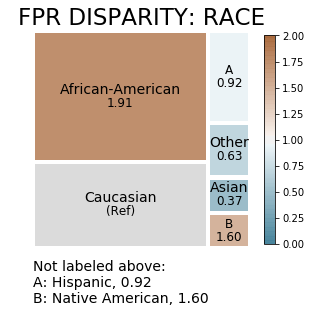

In [45]:
aqp.plot_disparity(bdf, group_metric='fpr_disparity', attribute_name='race', significance_alpha=0.05)

When another group, 'Hispanic', is the reference group, the colors change to indicate higher or lower disparity in relation to that group. Treemap square sizes may also be adjusted, as group size limits for visualization are in relation to the reference group (minimum 0.1 times reference group size and maximum 10 times the reference group size).

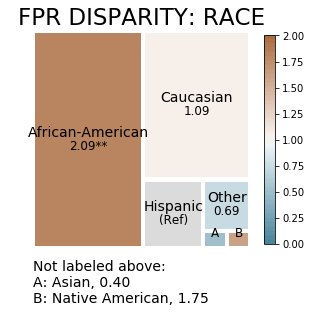

In [46]:
aqp.plot_disparity(hbdf, group_metric='fpr_disparity', attribute_name='race', significance_alpha=0.05)

### Visualizing disparities between all groups for a single user-specified disparity metric

The treemaps belows display False Positive Rate disparities calculated based on predefined reference groups ('race' attribute: Hispanic, 'sex' attribute: Male, 'age_cat' attribute: 25-45), sized based on group size, and colored based on disparity magnitude. 

It is clear that the majority of samples in the data are African-American, male, and 25-45 for the 'race', 'sex', and age category attributes, respectively. Based on the lighter colors in the treemaps, we see that there is precision disparity relatively close to 1 (a disparity of 1 indicates no disparity) across all attributes.

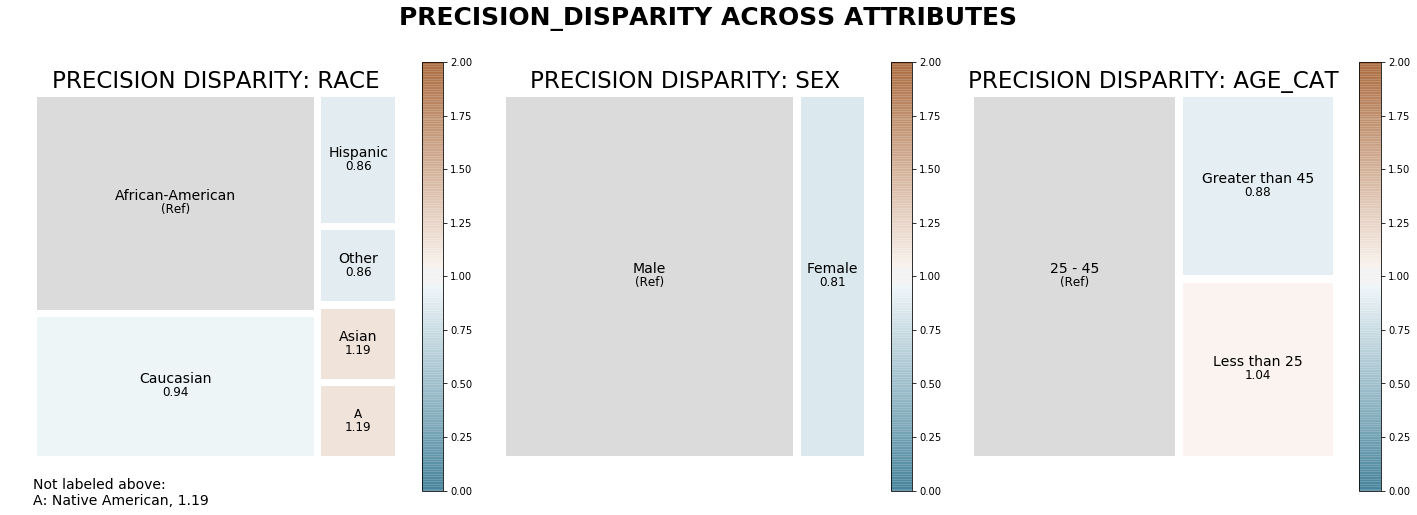

In [47]:
j = aqp.plot_disparity_all(majority_bdf, metrics=['precision_disparity'], significance_alpha=0.05)

### Visualizing disparities between groups in a single user-specified attribute for default metrics
##### Default Metrics
When visualizing more than one disparity, you can specify a list of disparity metrics, `'all'` disaprity metrics, or use the Aequitas default disparity metrics by not supplying an argument:
- Predicted Positive Group Rate Disparity (pprev_disparity),
- Predicted Positive Rate Disparity (ppr_disparity),
- False Discovery Rate Disparity (fdr_disparity),
- False Omission Rate Disparity (for_disparity)
- False Positive Rate Disparity (fpr_disparity)
- False Negative Rate Disparity (fnr_disparity)

The treemaps below display the default disparities between 'age_cat' groups calculated based on the minimum value of each metric, colored based on disparity magnitude. We can see based on coloring that there is a lower level of false discovery rate disparity ('fdr_disparity') between age categories than predicted positive group rate disparity or ('pprev_disparity') predicted positive rate disparity ('ppr_disparity').

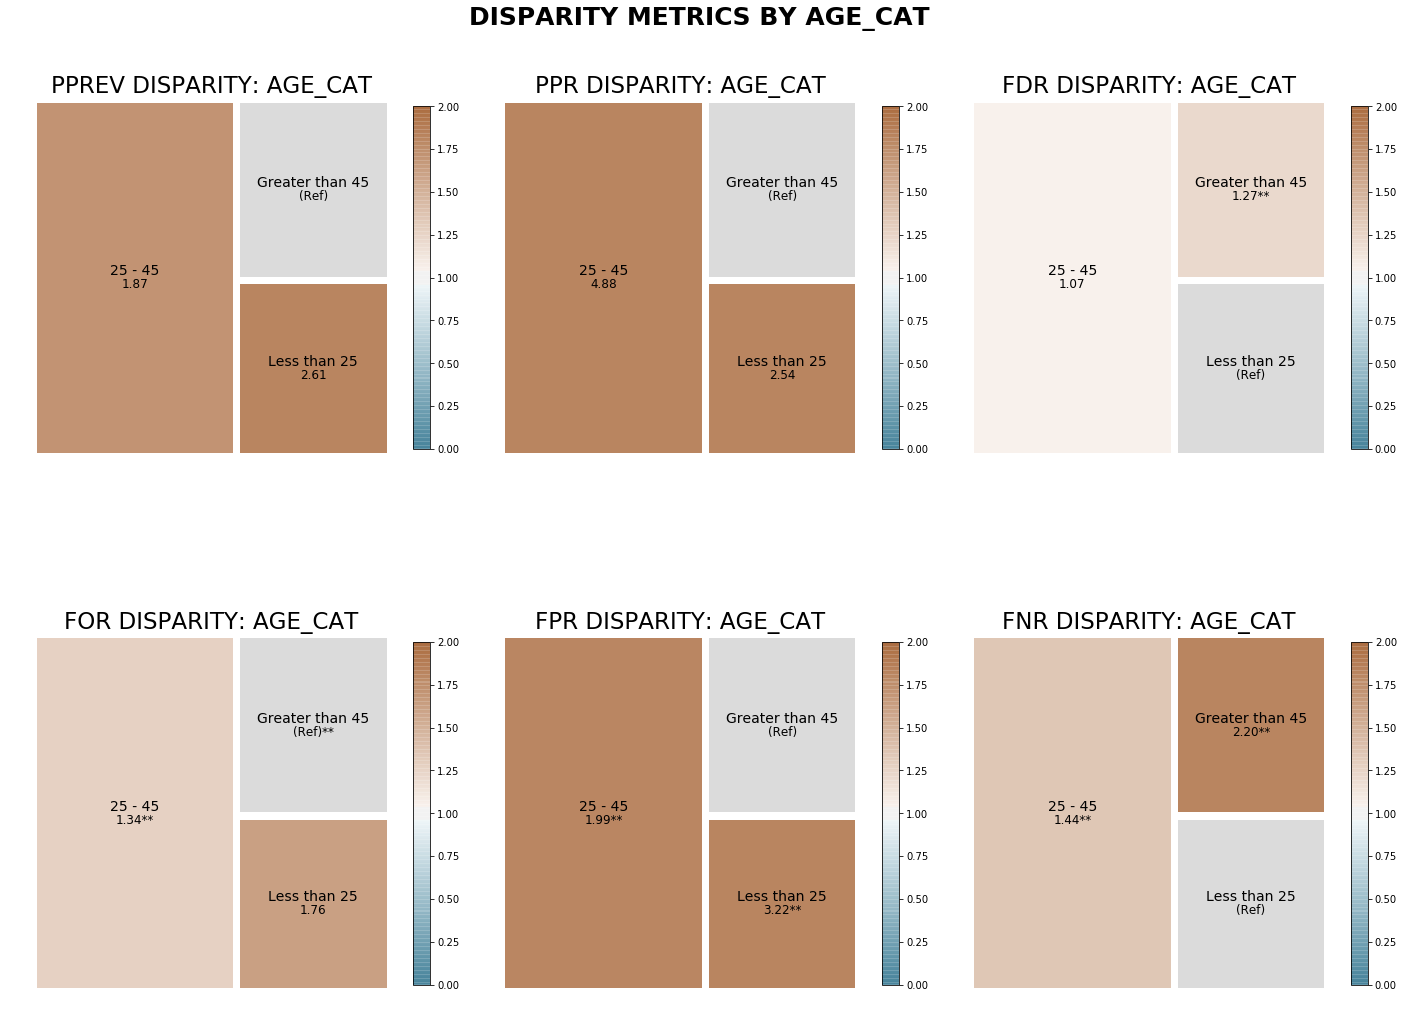

In [48]:
min_met = aqp.plot_disparity_all(min_metric_bdf, attributes=['age_cat'], significance_alpha=0.05)

### Visualizing disparities between groups in a single user-specified attribute for all calculated disparity metrics

The treemaps below display disparities between 'race' attribute groups calculated based on predefined reference groups ('race' attribute: Hispanic, 'sex' attribute: Male, 'age_cat' attribute: 25-45) for all 10 disparity metrics, colored based on disparity magnitude.

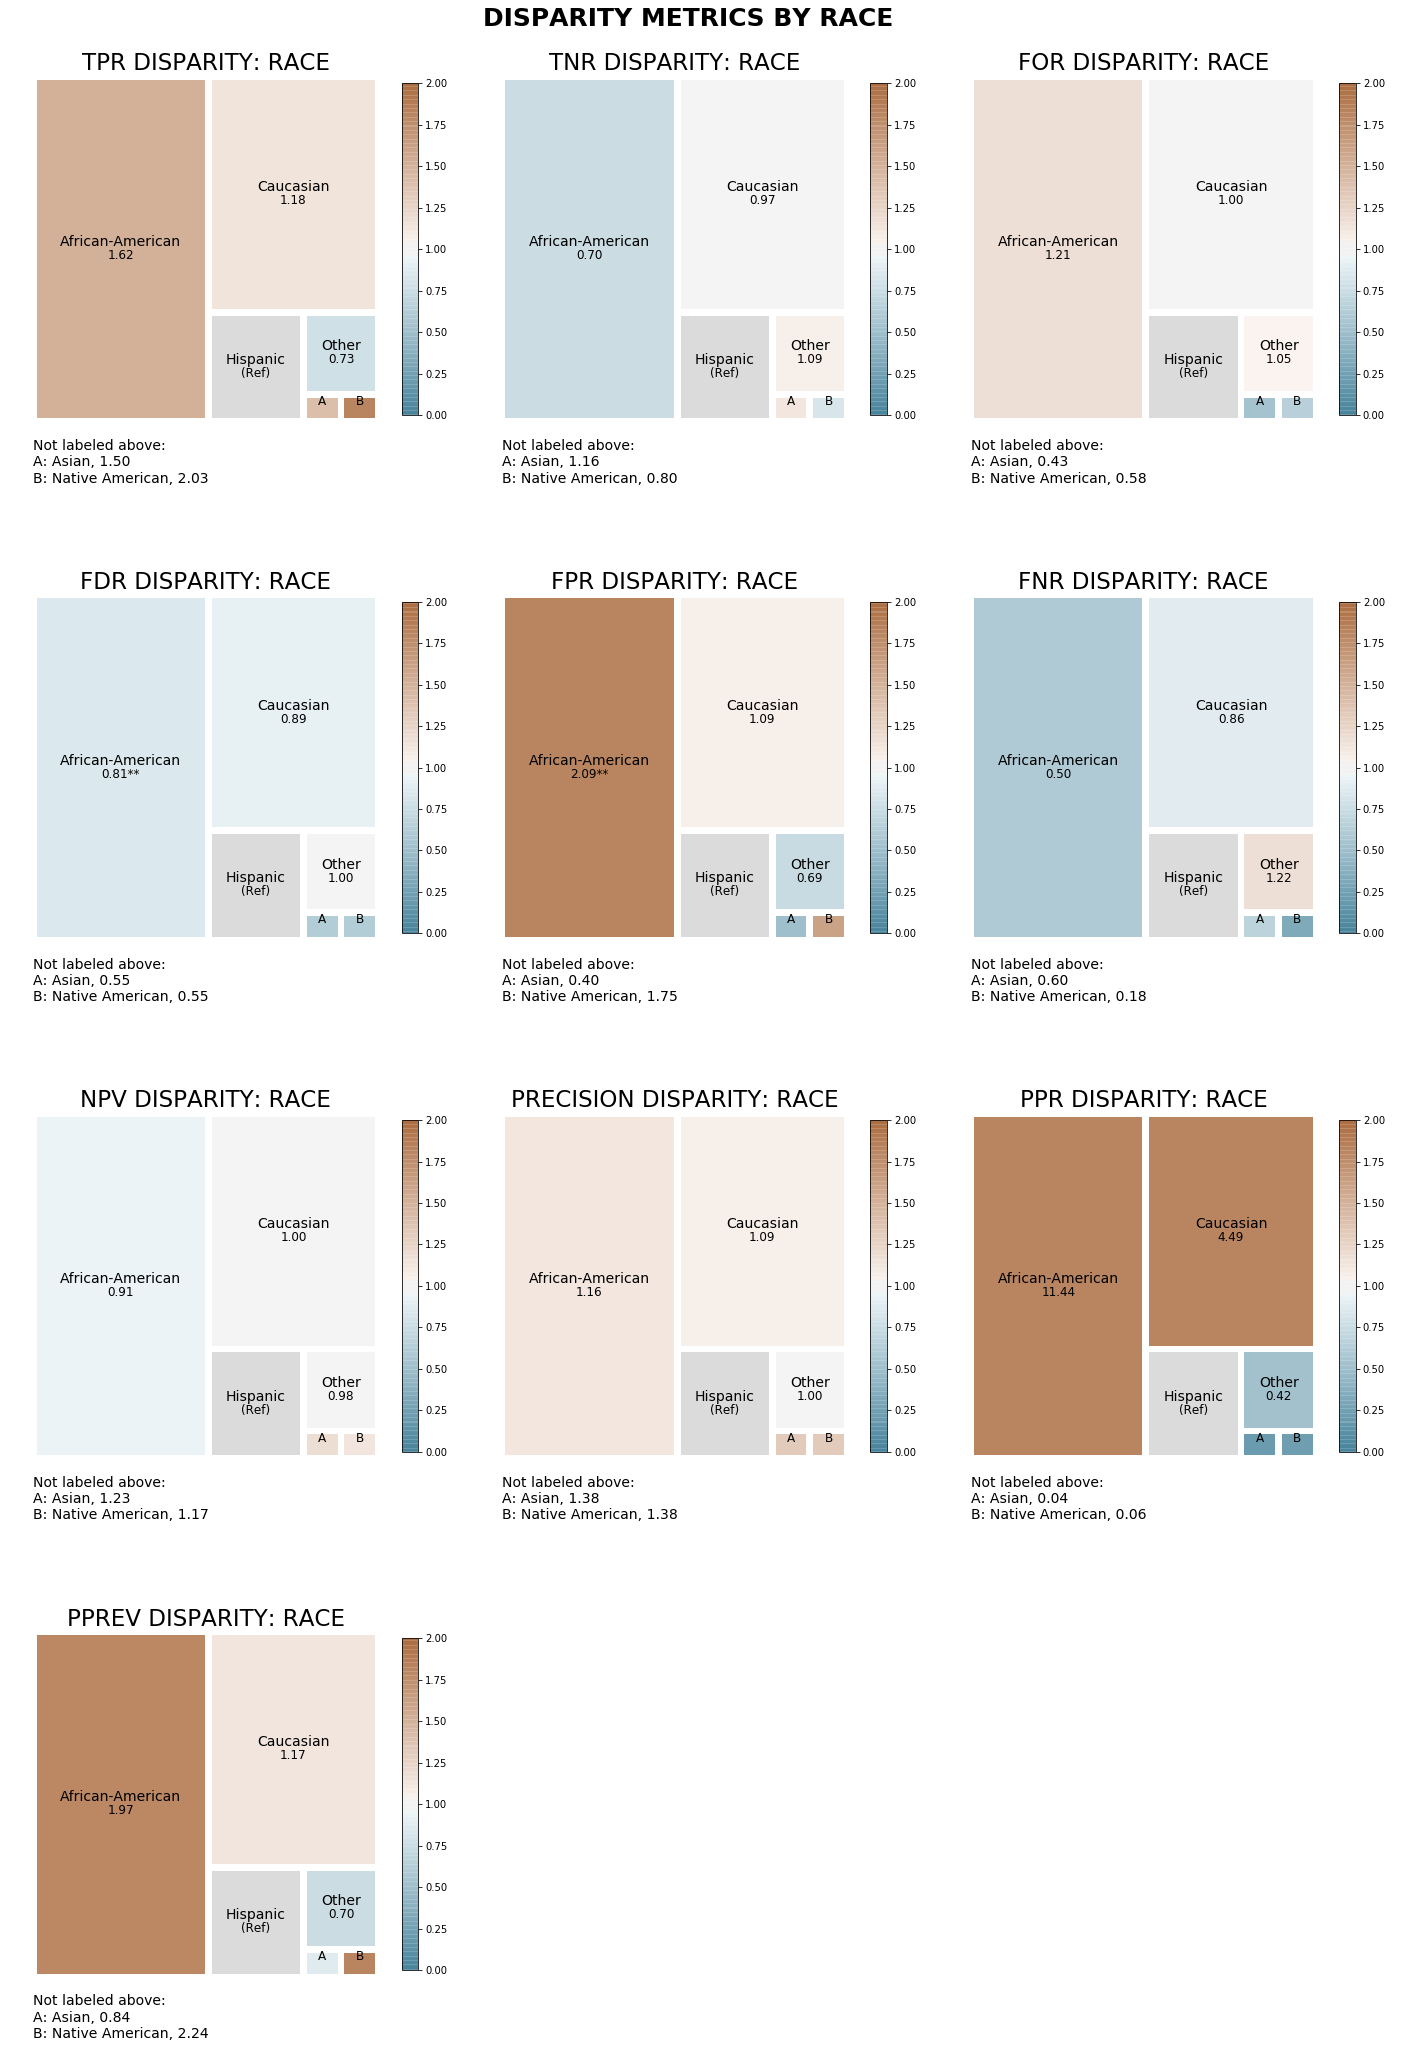

In [49]:
tm_capped = aqp.plot_disparity_all(hbdf, attributes=['race'], metrics = 'all', significance_alpha=0.05)

### Visualizing disparity between all groups for multiple user-specified disparity metrics

The treemaps below display False Omission Rate and False Positive Rate disparities (calculated in relation to the sample majority group for each attribute) between groups acorss all three attributes, colored based on disparity magnitude.

We see that several groups (Asian, Native American) have a much lower false omission rate than African Americans, with fairly close false omission rates between the sexes and the two older oldest age groups. Though there are many more men in the sample, the two groups have nearly identical false positive rates, while color tells us that there are larger false positive rate disparities between races and age categories than false omission rate disparity.

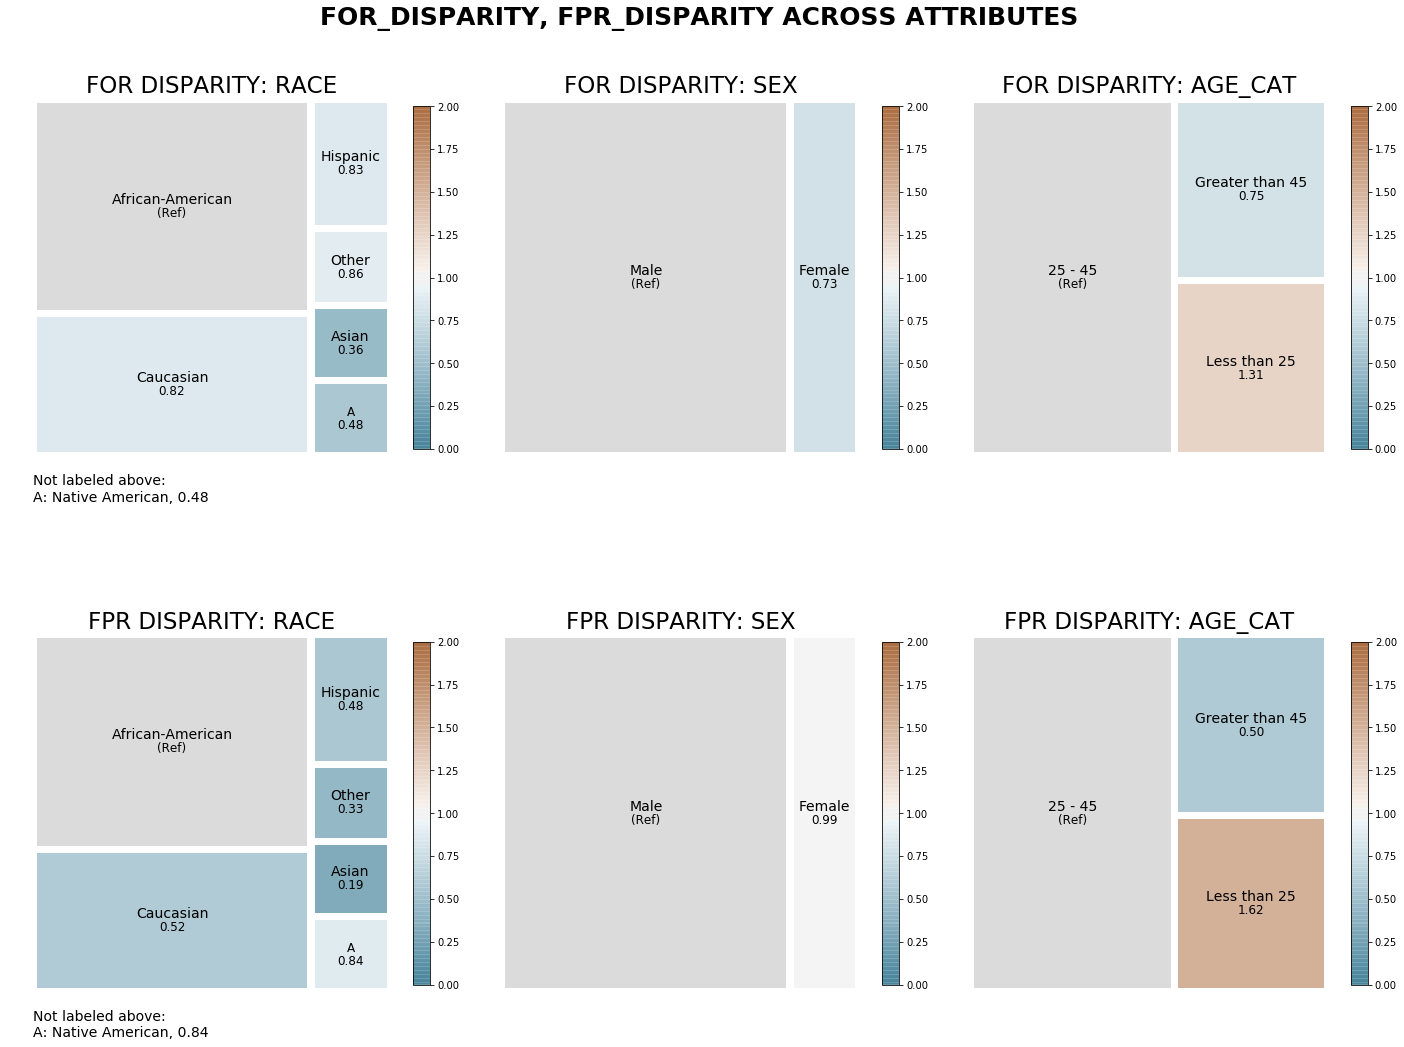

In [50]:
dp = aqp.plot_disparity_all(majority_bdf, metrics=['for_disparity', 'fpr_disparity'], significance_alpha=0.05)

[Back to Top](#top_cell)
<a id='fairness'></a>

## How do I assess model fairness?

### _Aequitas Fairness() Class_
Finally, the Aequitas `Fairness()` class provides three functions that provide a high level summary of fairness. This class builds on the dataframe returned from one of the three `Bias()` class **`get_dispariy_`** methods. 

Using FPR disparity as an example and the default fairness threshold, we have:

$$ 0.8 < Disparity_{FNR} =  \frac{FPR_{group}}{FPR_{base group}} < 1.25 $$ 

We can assess fairness at various levels of detail:

### Group Level Fairness
When the `label_value` column is not included in the original data set, Aequitas calculates only Statistical Parity and Impact Parities.

When the `label_value` is included in the original data set, the **`get_group_value_fairness()`** function builds on the previous dataframe. The **`get_group_value_fairness()`**
function gives us attribute group-level statistics for fairness determinations:

#### Pairities Calcuated:

| Parity | Column Name |
| --- | --- |
| True Positive Rate Parity | 'TPR Parity' |
| True Negative Rate Parity | 'TNR Parity' |
| False Omission Rate Parity | 'FOR Parity' |
| False Discovery Rate Parity | 'FDR Parity' |
| False Positive Rate Parity | 'FPR Parity' |
| False Negative Rate Parity | 'FNR Parity' |
| Negative Predictive Value Parity | 'NPV Parity' |
| Precision Parity | 'Precision Parity' |
| Predicted Positive Ratio$_k$ Parity | 'Statistical Parity' |
| Predicted Positive Ratio$_g$ Parity | 'Impact Parity' |

#### Also assessed:
- **_Type I Parity_**: Fairness in both FDR Parity and FPR Parity
- **_Type II Parity_**: Fairness in both FOR Parity and FNR Parity
- **_Equalized Odds_**: Fairness in both FPR Parity and TPR Parity
- **_Unsupervised Fairness_**: Fairness in both Statistical Parity and Impact Parity
- **_Supervised Fairness_**: Fairness in both Type I and Type II Parity
- **_Overall Fairness_**: Fairness across all parities for all attributes

In [51]:
f = Fairness()
fdf = f.get_group_value_fairness(bdf)

The `Fairness()` class includes a method to quickly return a list of fairness determinations from the dataframe returned by the **`get_group_value_fairness()`** method.

In [52]:
parity_detrminations = f.list_parities(fdf)

In [53]:
fdf[['attribute_name', 'attribute_value'] + absolute_metrics + calculated_disparities + parity_detrminations].style

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev,fdr_disparity,fnr_disparity,for_disparity,fpr_disparity,npv_disparity,ppr_disparity,pprev_disparity,precision_disparity,tnr_disparity,tpr_disparity,Supervised Fairness,Equalized Odds,NPV Parity,FDR Parity,TPR Parity,FPR Parity,TypeI Parity,Precision Parity,Statistical Parity,FNR Parity,TypeII Parity,FOR Parity,TNR Parity,Impact Parity,Unsupervised Fairness
0,race,African-American,0.720147,0.551532,0.34954,0.370285,0.448468,0.279853,0.65046,0.629715,0.655412,0.588203,0.51434,0.906085,0.586416,1.21315,1.91209,0.913728,2.54567,1.69022,1.0649,0.720526,1.37755,False,False,True,True,False,False,False,True,False,False,False,True,False,False,False
1,race,Asian,0.666667,0.913043,0.125,0.25,0.0869565,0.333333,0.875,0.75,0.00241182,0.25,0.28125,0.611748,0.698482,0.433839,0.370749,1.22915,0.00936768,0.718384,1.26832,1.19281,1.27525,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False
2,race,Caucasian,0.522774,0.765457,0.288125,0.408665,0.234543,0.477226,0.711875,0.591335,0.257462,0.348003,0.393643,1,1,1,1,1,1,1,1,1,1,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
3,race,Hispanic,0.443966,0.785185,0.288591,0.457895,0.214815,0.556034,0.711409,0.542105,0.0572807,0.298273,0.364207,1.12046,1.16514,1.00162,0.915887,0.999346,0.222482,0.857099,0.916748,1.02577,0.849249,True,True,True,True,True,True,True,True,False,True,True,True,True,True,False
4,race,Native American,0.9,0.625,0.166667,0.25,0.375,0.1,0.833333,0.75,0.00361773,0.666667,0.555556,0.611748,0.209544,0.578453,1.59885,1.17062,0.0140515,1.91569,1.26832,0.816506,1.72158,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False
5,race,Other,0.323308,0.852459,0.302013,0.455696,0.147541,0.676692,0.697987,0.544304,0.0238167,0.209549,0.352785,1.11508,1.41797,1.0482,0.629057,0.98049,0.0925059,0.602147,0.920466,1.11366,0.618447,False,False,True,True,False,False,False,True,False,False,False,True,True,False,False
6,sex,Female,0.608434,0.67893,0.242537,0.48731,0.32107,0.391566,0.757463,0.51269,0.178173,0.423656,0.356989,1.33642,1.05581,0.734738,0.990343,1.13071,0.216801,0.904348,0.806925,1.00463,0.967101,False,True,True,False,True,True,False,True,False,True,False,False,True,True,False
7,sex,Male,0.629132,0.675799,0.3301,0.364637,0.324201,0.370868,0.6699,0.635363,0.821827,0.468465,0.473105,1,1,1,1,1,1,1,1,1,1,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
8,age_cat,25 - 45,0.626257,0.666216,0.323112,0.385135,0.333784,0.373743,0.676888,0.614865,0.580042,0.46824,0.459723,1,1,1,1,1,1,1,1,1,1,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
9,age_cat,Greater than 45,0.427711,0.832096,0.241117,0.459391,0.167904,0.572289,0.758883,0.540609,0.118782,0.25,0.31599,1.1928,1.53124,0.746232,0.503031,1.12114,0.204782,0.533914,0.879232,1.24899,0.682963,False,False,True,True,False,False,False,True,False,False,False,False,True,False,False


[Back to Top](#top_cell)
<a id='interpret_fairness'></a>

### How do I interpret parities?
Calling the Aequitas `Fairness()` class **`get_group_value_fairness()`** method on the dataframe returned from a `Bias()` class `get_dispariy` method will return the dataframe with additional columns indicating parities, as seen in the slice of the `get_group_value_fairness` data frame directly above.

In this case, our base groups are Caucasian for race, Male for gender, and 25-45 for age_cat. By construction, the base group has supervised fairness. (The disparity ratio is 1). Relative to the base groups, the COMPAS predictions only provide supervised fairness to one group, Hispanic.

Above, the African-American false omission and false discovery are within the bounds of fairness. This result is expected because COMPAS is calibrated. (Given calibration, it is surprising that Asian and Native American rates are so low. This may be a matter of having few observations for these groups.)

On the other hand, African-Americans are roughly twice as likely to have false positives and 40 percent less likely to false negatives. In real terms, 44.8% of African-Americans who did not recidivate were marked high or medium risk (with potential for associated penalties), compared with 23.4% of Caucasian non-reoffenders. This is unfair and is marked False below.

These findings mark an inherent trade-off between FPR Fairness, FNR Fairness and calibration, which is present in any decision system where base rates are not equal. See [Chouldechova (2017)](https://www.andrew.cmu.edu/user/achoulde/files/disparate_impact.pdf). Aequitas helps bring this trade-off to the forefront with clear metrics and asks system designers to make a reasoned decision based on their use case.

### Attribute Level Fairness
Use the **`get_group_attribute_fairness()`** function to view only the calculated parities from the **`get_group_value_fairness()`** function at the attribute level.

In [54]:
gaf = f.get_group_attribute_fairness(fdf)
gaf

,model_id,score_threshold,attribute_name,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,0,binary 0/1,age_cat,False,False,True,False,False,False,False,False,True,True,False,False,False,False,False
1,0,binary 0/1,race,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
2,0,binary 0/1,sex,False,True,False,True,False,True,True,True,True,True,False,False,True,False,False


### Overall Fairness
The **`get_overall_fairness()`** function gives a quick boolean assessment of the output of **`get_group_value_fairness()`** or **`get_group_attribute_fairness()`**, returning a dictionary with a determination across all attributes for each of:
- Unsupervised Fairness
- Supervised Fairness
- Overall Fairness

In [55]:
gof = f.get_overall_fairness(fdf)
gof

{'Unsupervised Fairness': False,
 'Supervised Fairness': False,
 'Overall Fairness': False}

[Back to Top](#top_cell)
<a id='fairness_group_viz'></a>

## How do I visualize bias metric parity?
Once you have run the `Group()` class to retrieve a crosstab of absolute group value bias metrics, added calculdated disparities via one of the the `Bias()` class **`get_disparity`** functions, and added parity determinations via the `Fairness()` class **`get_group_value_fairness()`** or **`get_group_attribute_fairness()`** method, you are ready to visualize biases and disparities in terms of fairness determination.

For visualizing absolute metric fairness with the the Aequitas `Plot()` class, a particular metric can be specified with **`plot_fairness_group()`**. A list of particular metrics of interest or 'all' metrics can be plotted with **`plot_fairness_group_all()`**.

### Visualizing parity of a single absolute group metric across all population groups

The chart below displays absolute group metric Predicted Positive Rate Disparity (ppr) across each attribute, colored based on fairness determination for that attribute group (green = 'True' and red = 'False'). 

We can see from the green color that only the 25-45 age group, Male category, and Caucasian groups have been determined to be fair. Sound familiar? They should! These are the groups selected as reference groups, so this model is not fair in terms of Statistical Parity for any of the other groups.

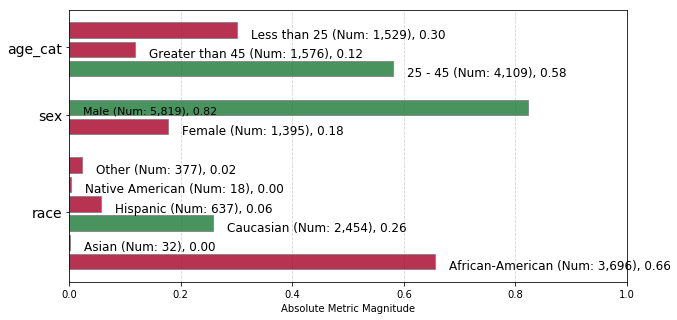

In [56]:
z = aqp.plot_fairness_group(fdf, group_metric='ppr')

### Visualizing all absolute group metrics across all population groups
The charts below display all calculated absolute group metrics across each attribute, colored based on fairness determination for that attribute group (green = 'True' and red = 'False'). 

Immediately we can see that negative predictive parity status is 'True' for all population groups, and that only two groups had a 'False' determination for true negative parity. 

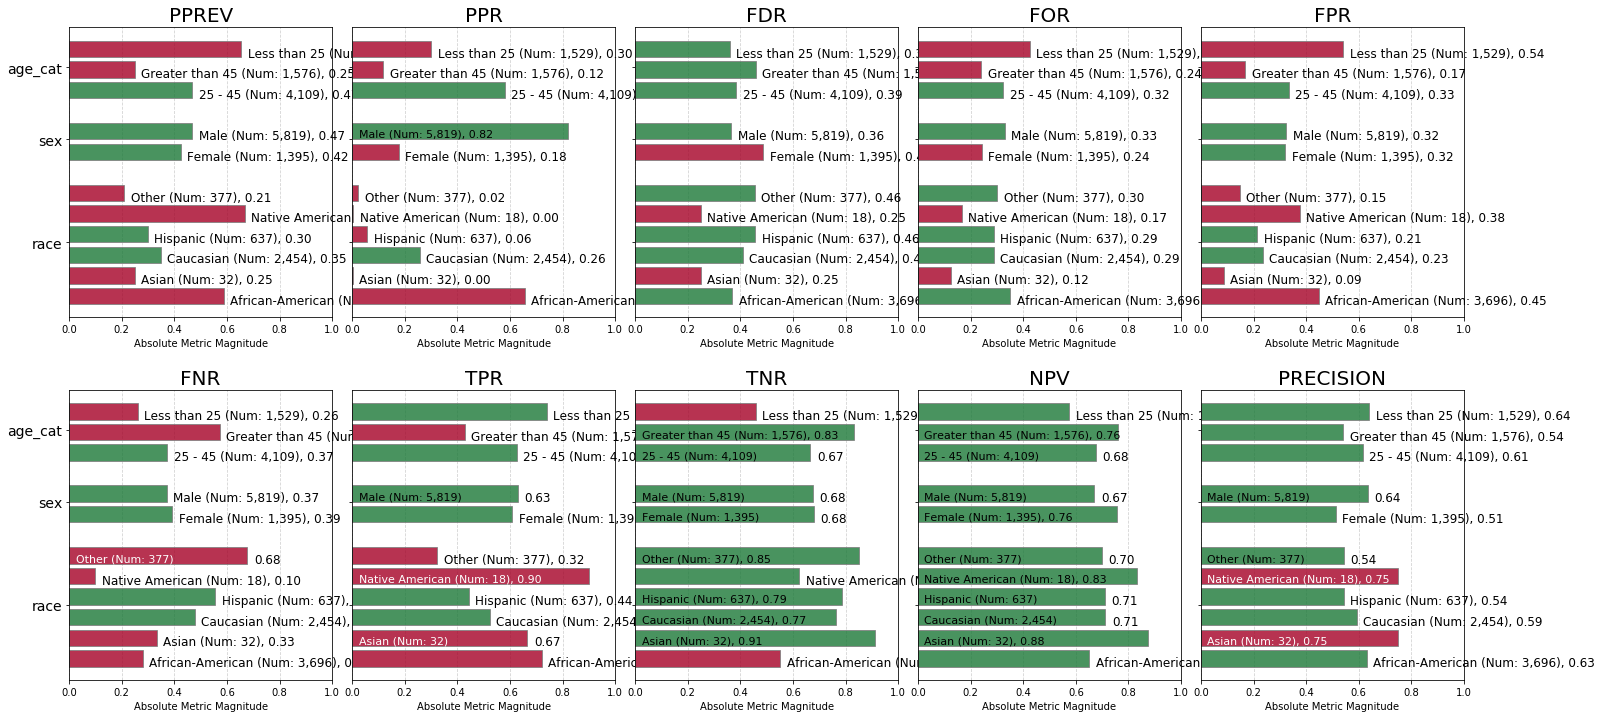

<Figure size 432x288 with 0 Axes>

In [57]:
fg = aqp.plot_fairness_group_all(fdf, ncols=5, metrics = "all")

[Back to Top](#top_cell)
<a id='fairness_disp_viz'></a>

## How do I visualize parity between groups in my model? 
To visualize disparity fairness based on the dataframe returned from the Fairness() class **`get_group_value_fairness()`** method, a particular disparity metric can be specified with the **`plot_fairness_disparity()`** method in the the Aequitas `Plot()` class. To plot a single disparity, a metric and an attribute must be specified.

Disparities related to a list of particular metrics of interest or `'all'` metrics can be plotted with **`plot_fairness_disparity_all()`**. At least one metric or at least one attribute **must** be specified when plotting multiple fairness disparities (or the same disparity across multiple attributes).

### Visualizing parity between groups in a single user-specified attribute for all calculated disparity metrics

The treemap below displays False Discovery Rate disparity values between race attribute groups calculated based on a predefined reference group ('Caucasian'), colored based on fairness determination for that attribute group (green = 'True' and red = 'False'). We see very quickly that only two groups have a 'False' parity determination.

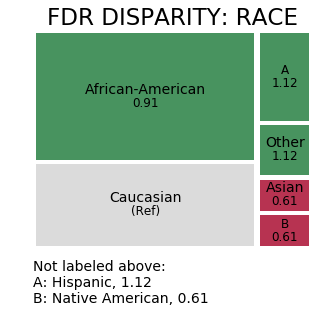

In [58]:
m = aqp.plot_fairness_disparity(fdf, group_metric='fdr', attribute_name='race')

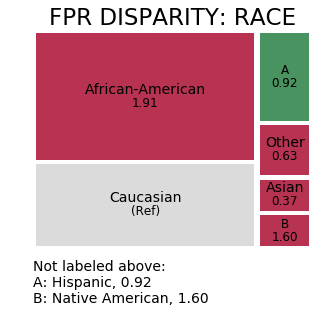

In [59]:
fpr = aqp.plot_fairness_disparity(fdf, group_metric='fpr', attribute_name='race')

### Researcher Check: Could the unfairness I am seeing be related to small group sizes in my sample?

Use the `min_group` parameter on all visualization methods to vizualize parities for only those sample population groups above a user-specified percentage of the total sample size. Note that only the smallest groups had an 'False' determination for false discovery rate parity above. The parity determination is 'True' for all groups at least 1% of the sample size .

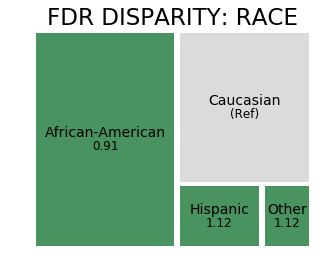

In [60]:
m = aqp.plot_fairness_disparity(fdf, group_metric='fdr', attribute_name='race', 
                                min_group_size=0.01, significance_alpha=0.05)

### Visualizing parity between groups in a single user-specified attribute for all calculated disparity metrics

The treemaps below display disparities between race attribute groups calculated based on a predefined reference group ('Caucasian') for all 10 disparity metrics, colored based on fairness determination for that attribute group (green = 'True' and red = 'False').

As all treemap squares are sized and positioned based on group size, the population groups on all subplots are found in the same place across all disparity metrics, allowing for ease of comparison of fairness determinations for each 'race' group across every calculated dipsarity metric.

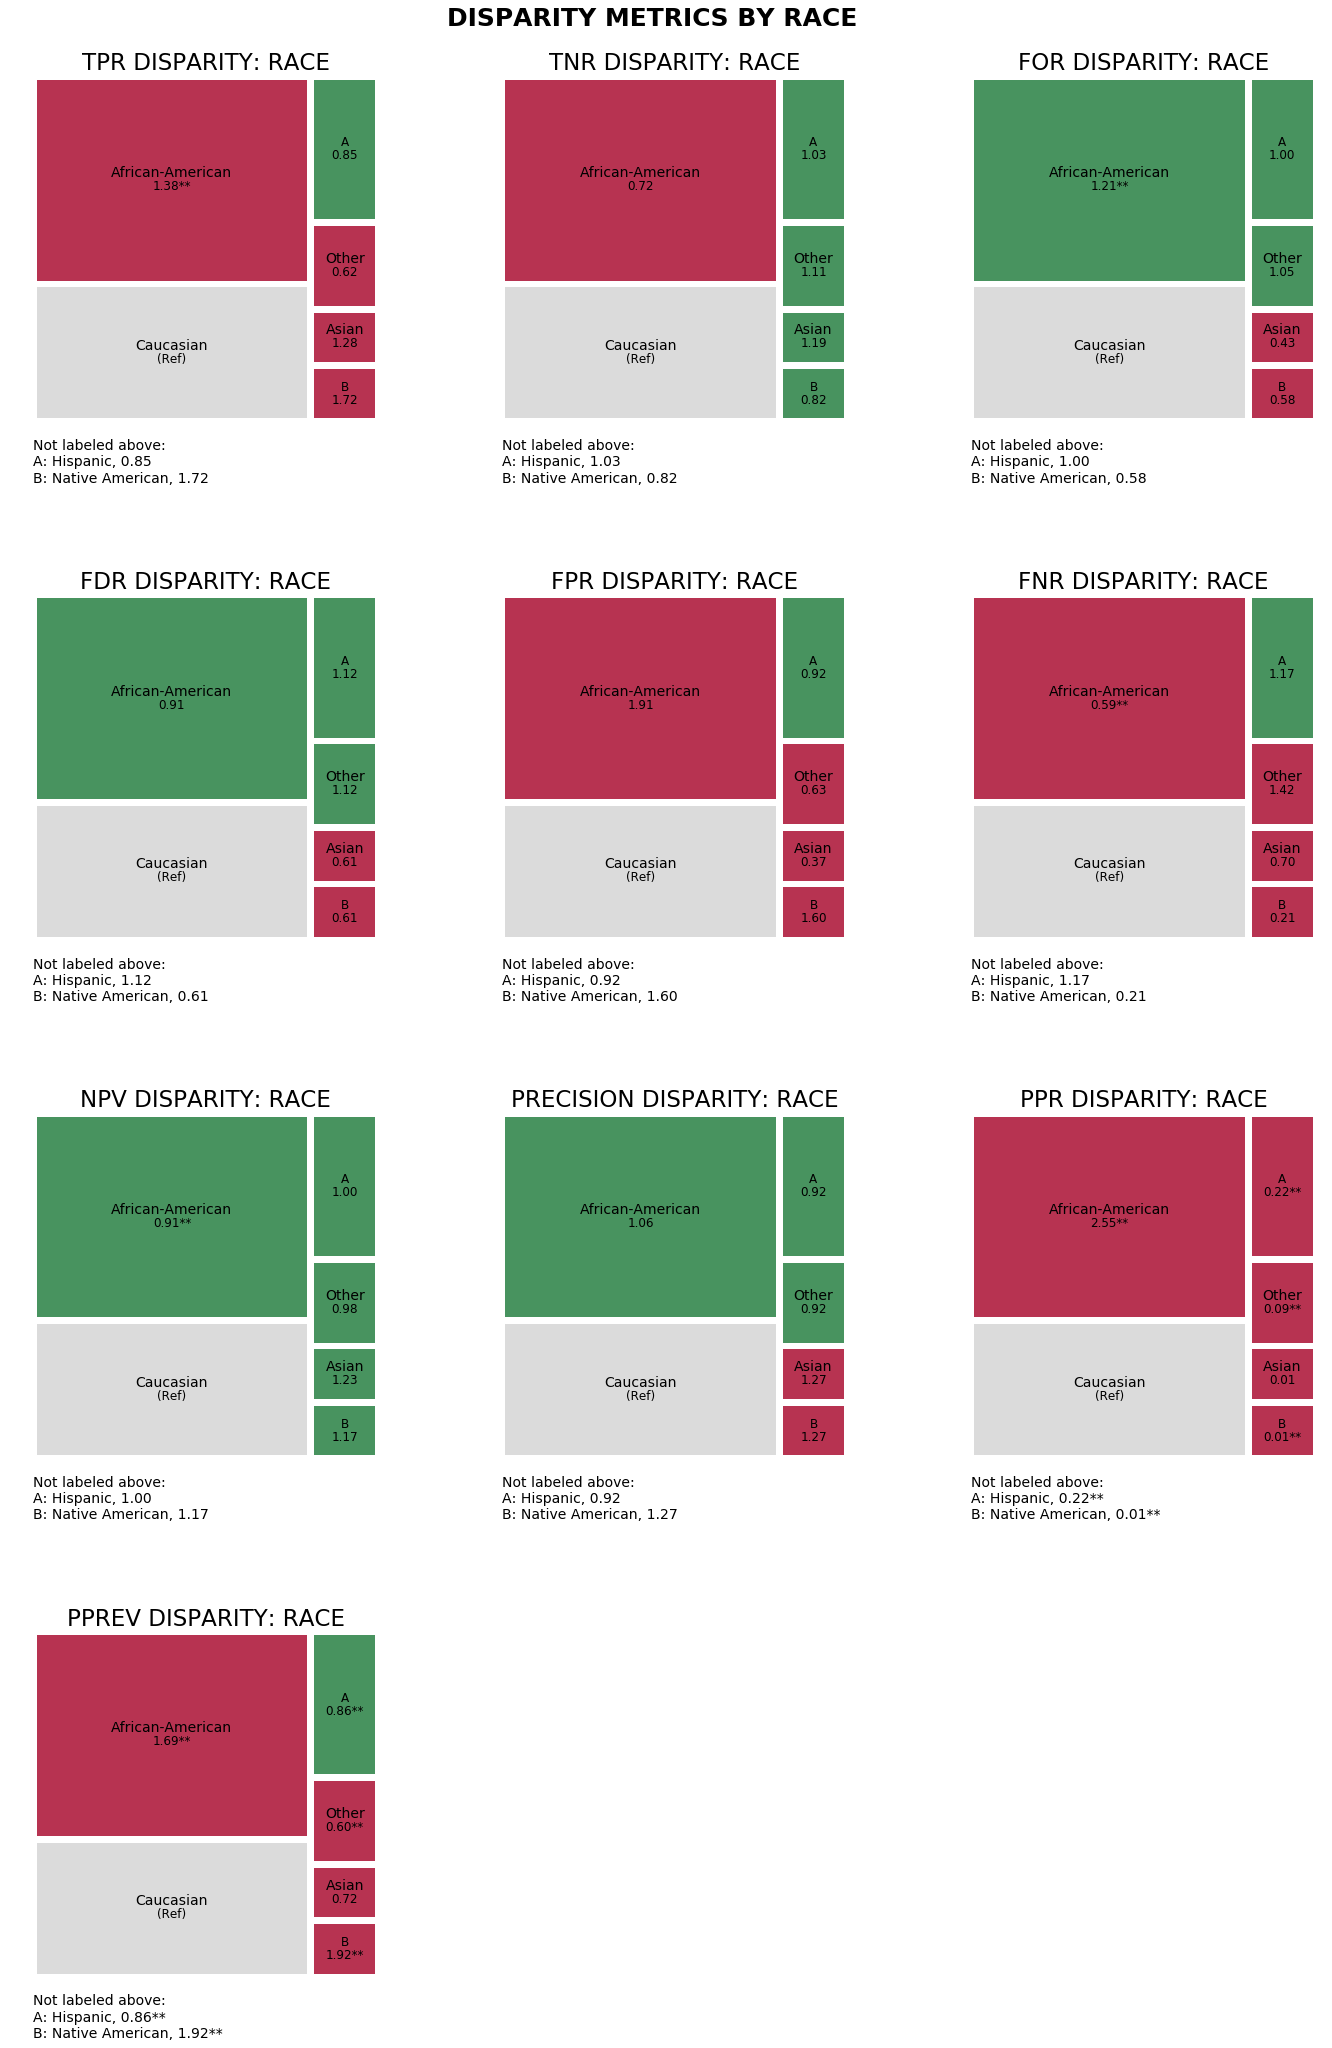

In [61]:
a_tm = aqp.plot_fairness_disparity_all(fdf, attributes=['race'], metrics='all', 
                                       significance_alpha=0.05)

### Visualizing parity between all groups for multiple user-specified disparity metrics

The treemaps below display Predicted Positive Group Rate (pprev) and Predicted Positive Rate (ppr) disparities between attribute groups for all three attributes (race, sex, age category) calculated based on predefined reference groups ('race' attribute: Caucasian, 'sex' attribute: Male, 'age_cat' attribute: 25-45), colored based on fairness determination for that attribute group (green = 'True' and red = 'False'). As we want to plot for all groups, there is no need to specify any attributes. 

We can see that the Predicted Positive Group Rate Parity (Impact Parity) determination was 'False' for nearly every race in comparison to Caucausians, and 'False' for every other age category in comparison to the 25-45 age group, and that overall Predicted Positive Rate Parity (Statistical Parity) did not have any 'True' fairness determinations at all.

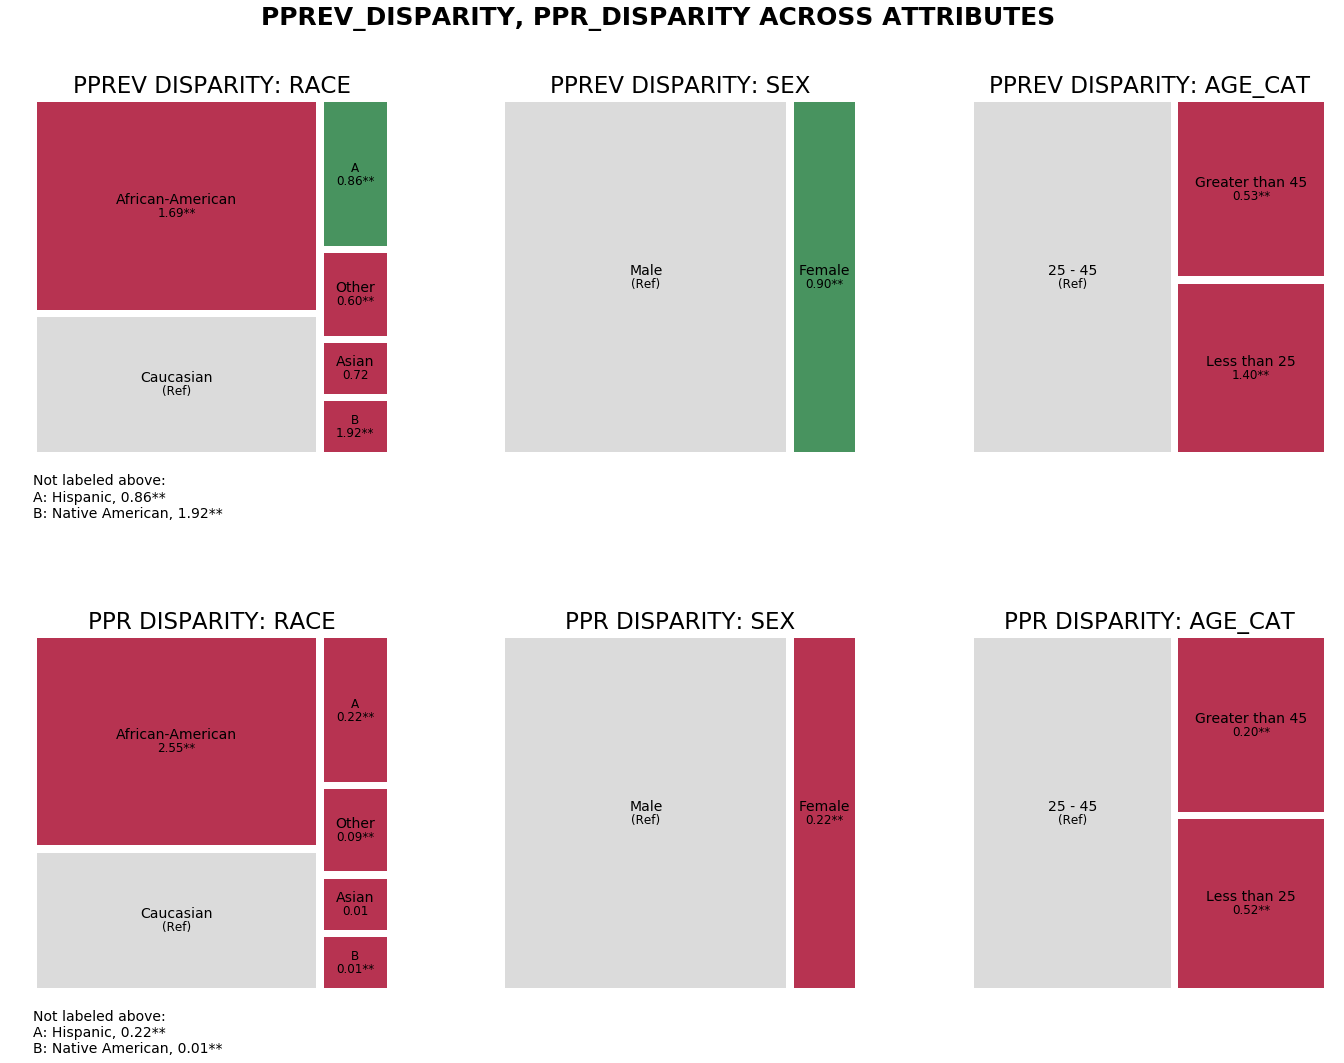

In [62]:
r_tm = aqp.plot_fairness_disparity_all(fdf, metrics=['pprev_disparity', 'ppr_disparity'], 
                                       significance_alpha=0.05)

### Visualizing parity between groups in multiple user-specified attributes

The treemaps below display disparities between attribute groups for all two attributes (sex, age category) calculated based on predefined reference groups ('sex' attribute: Male, 'age_cat' attribute: 25-45) for the six default disparity metrics, colored based on fairness determination for that attribute group (green = 'True' and red = 'False'). As we want to see only the default metrics, we do not need to set the 'metrics' parameter. 

Note that there is slightly more parity between the sexes (FNR, FDR, FNR, and Statistical Parity) than between age categories (FDR Parity only).

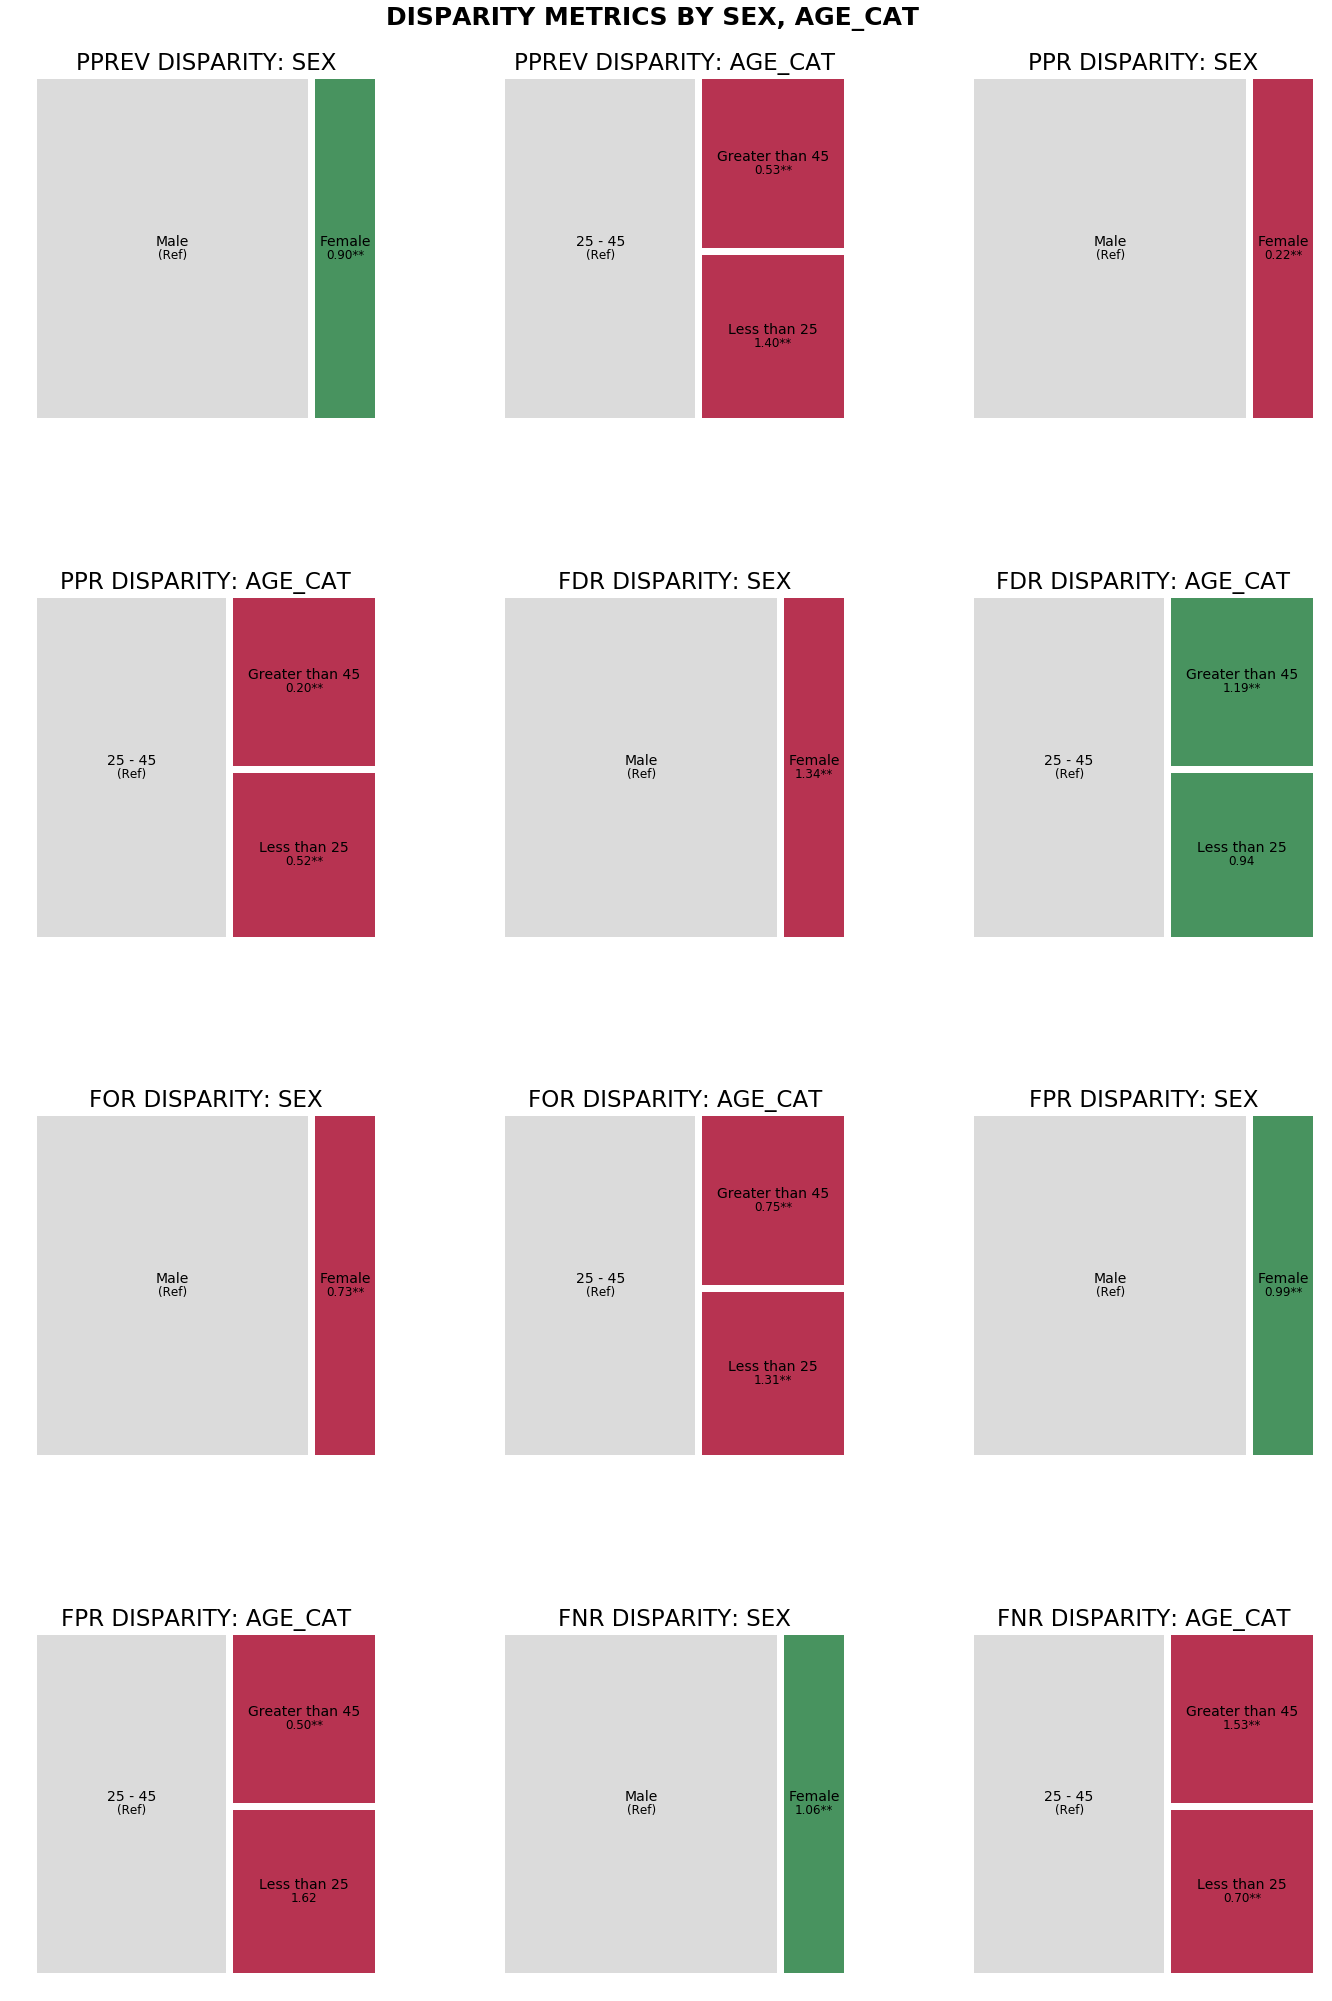

In [63]:
n_tm = aqp.plot_fairness_disparity_all(fdf, attributes=['sex', 'age_cat'], 
                                       significance_alpha=0.05)

## The Aequitas Effect

By breaking down the COMPAS predictions using a variety of bias and disparity metrics calculated using different reference groups, we are able to surface the specific metrics for which the model is imposing bias on given attribute groups, and have a clearer lens when evaluating models and making recommendations for intervention. 

Researchers utilizing Aequitas will be able to make similar evaluations on their own data sets, and as they continue to use the tool, will begin to identify patterns in where biases exist and which models appear to produce less bias, thereby helping to reduce bias and its effects in future algorithm-based decision-making.

[Back to Top](#top_cell)